<a href="https://colab.research.google.com/github/Noman-Sajal/Employment-Rate-Prediction-by-Neural-Network/blob/main/Final_Version_of_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
pip install dash plotly pandas


In [89]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
# All Necessary Library import
import json
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from tabulate import tabulate
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_percentage_error
from joblib import load
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go


In [91]:
# Load the downloaded JSON file
json_file_path = '/content/drive/My Drive/Employment Rate Prediction all Dataset/countries_data.json'


with open(json_file_path, 'r') as file:
    countries_data = json.load(file)

# Extract country, continent, area, latitude, and longitude information
country_info_list = []
for country in countries_data:
    country_name = country.get('name', {}).get('common')
    continent = country.get('region')
    area = country.get('area')  # Get the area
    latlng = country.get('latlng', [])  # Get latitude and longitude
    latitude = latlng[0] if len(latlng) > 0 else None  # First element is latitude
    longitude = latlng[1] if len(latlng) > 1 else None  # Second element is longitude

    country_info_list.append({
        'Country Name': country_name,
        'Continent': continent,
        'Area': area,
        'Latitude': latitude,
        'Longitude': longitude
    })

# Convert the country information into a DataFrame
country_info_df = pd.DataFrame(country_info_list)

# Display the first few rows to verify the changes
print(country_info_df.head())


    Country Name  Continent     Area   Latitude  Longitude
0  South Georgia  Antarctic   3903.0 -54.500000 -37.000000
1        Grenada   Americas    344.0  12.116667 -61.666667
2    Switzerland     Europe  41284.0  47.000000   8.000000
3   Sierra Leone     Africa  71740.0   8.500000 -11.500000
4        Hungary     Europe  93028.0  47.000000  20.000000


In [92]:
# Paths to the datasets in Google Drive
gdp_file_path = '/content/drive/My Drive/Employment Rate Prediction all Dataset/gdp_data.csv'
labor_force_file_path = '/content/drive/My Drive/Employment Rate Prediction all Dataset/labor_force_data.csv'
inflation_file_path = '/content/drive/My Drive/Employment Rate Prediction all Dataset/inflation_data.csv'
population_growth_file_path = '/content/drive/My Drive/Employment Rate Prediction all Dataset/population_growth_data.csv'
gdp_growth_file_path = '/content/drive/My Drive/Employment Rate Prediction all Dataset/gdp_growth_data.csv'
trade_file_path = '/content/drive/My Drive/Employment Rate Prediction all Dataset/trade_data.csv'
employment_file_path = '/content/drive/My Drive/Employment Rate Prediction all Dataset/employment_data.csv'

# Load the World Bank datasets
gdp_df = pd.read_csv(gdp_file_path)
labor_force_df = pd.read_csv(labor_force_file_path)
inflation_df = pd.read_csv(inflation_file_path)
population_growth_df = pd.read_csv(population_growth_file_path)
gdp_growth_df = pd.read_csv(gdp_growth_file_path)
trade_df = pd.read_csv(trade_file_path)
employment_df = pd.read_csv(employment_file_path)

# Verify the datasets were loaded successfully
print("GDP DataFrame Shape:", gdp_df.shape)
print("Labor Force DataFrame Shape:", labor_force_df.shape)
print("Inflation DataFrame Shape:", inflation_df.shape)
print("Population Growth DataFrame Shape:", population_growth_df.shape)
print("GDP Growth DataFrame Shape:", gdp_growth_df.shape)
print("Trade DataFrame Shape:", trade_df.shape)
print("Employment DataFrame Shape:", employment_df.shape)


GDP DataFrame Shape: (222, 28)
Labor Force DataFrame Shape: (222, 28)
Inflation DataFrame Shape: (222, 28)
Population Growth DataFrame Shape: (222, 28)
GDP Growth DataFrame Shape: (222, 28)
Trade DataFrame Shape: (222, 28)
Employment DataFrame Shape: (222, 28)


In [93]:
# Create a set of unique country names from both datasets to check mismatches
world_bank_countries = set(gdp_df['Country Name'].unique())
api_countries = set(country_info_df['Country Name'].unique())

# Find mismatches: Countries in the World Bank dataset not in the API dataset
mismatched_countries = world_bank_countries - api_countries

# Display mismatched countries
print(f"Number of mismatched countries: {len(mismatched_countries)}")
print("Mismatched countries:", mismatched_countries)


# Dictionary to map country names from API to World Bank dataset format
country_name_mapping = {
    'Bahamas': 'Bahamas, The',
    'Brunei': 'Brunei Darussalam',
    'Cape Verde': 'Cabo Verde',
    'Republic of the Congo': 'Congo, Rep.',
    'DR Congo':'Congo, Dem. Rep.',
    'Ivory Coast':"Cote d'Ivoire",
    'Curaçao': 'Curacao',
    'Egypt': 'Egypt, Arab Rep.',
    'Gambia': 'Gambia, The',
    'Hong Kong': 'Hong Kong SAR, China',
    'Iran': 'Iran, Islamic Rep.',
    'North Korea': 'Korea, Dem. People’s Rep.',
    'South Korea': 'Korea, Rep.',
    'Kyrgyzstan': 'Kyrgyz Republic',
    'Yemen': 'Yemen, Rep.',
    'Laos': 'Lao PDR',
    'Macau': 'Macao SAR, China',
    'Micronesia': 'Micronesia, Fed. Sts.',
    'Russia': 'Russian Federation',
    'São Tomé and Príncipe': 'Sao Tome and Principe',
    'Sint Maarten': 'Sint Maarten (Dutch part)',
    'Slovakia': 'Slovak Republic',
    'Saint Kitts and Nevis': 'St. Kitts and Nevis',
    'Saint Lucia': 'St. Lucia',
    'Saint Martin': 'St. Martin (French part)',
    'Saint Vincent and the Grenadines': 'St. Vincent and the Grenadines',
    'British Virgin Islands': 'Virgin Islands (U.S.)',
    'Syria': 'Syrian Arab Republic',
    'Turkey': 'Turkiye',
    'Venezuela': 'Venezuela, RB',
    'Vietnam': 'Viet Nam'
}


Number of mismatched countries: 34
Mismatched countries: {'Viet Nam', 'Yemen, Rep.', "Korea, Dem. People's Rep.", nan, 'Russian Federation', 'Iran, Islamic Rep.', 'Curacao', 'Congo, Dem. Rep.', 'Kyrgyz Republic', 'Micronesia, Fed. Sts.', 'Lao PDR', 'Hong Kong SAR, China', 'Sint Maarten (Dutch part)', 'Venezuela, RB', 'Turkiye', 'Syrian Arab Republic', 'Macao SAR, China', 'Sao Tome and Principe', 'Gambia, The', 'Cabo Verde', 'Virgin Islands (U.S.)', 'Slovak Republic', 'Brunei Darussalam', 'Channel Islands', "Cote d'Ivoire", 'Bahamas, The', 'Congo, Rep.', 'St. Lucia', 'St. Vincent and the Grenadines', 'Korea, Rep.', 'St. Martin (French part)', 'Egypt, Arab Rep.', 'West Bank and Gaza', 'St. Kitts and Nevis'}


In [94]:
# Define a function to merge datasets and reorder columns
def merge_and_reorder(df, country_info_df):
    merged_df = pd.merge(df, country_info_df, on='Country Name', how='left')

    # Reorder columns to place 'Continent', 'Area', 'Latitude', and 'Longitude' in the desired positions
    columns = merged_df.columns.tolist()
    columns_to_move = ['Continent', 'Area', 'Latitude', 'Longitude']

    # Remove the columns from their current positions
    for col in columns_to_move:
        columns.remove(col)

    # Insert the columns in the desired positions (after 'Country Name' and 'Country Code')
    for i, col in enumerate(columns_to_move):
        columns.insert(3 + i, col)  # Insert starting at index 3 for 4th position

    # Reorder the DataFrame using the new column order
    return merged_df[columns]

# Function to clean unwanted footer text (Meta Data) from DataFrames
def clean_footer(df):
    # Replace footer text with NaN
    footer_texts = ["Data from database: World Development Indicators", "Last Updated: 09/19/2024"]
    for footer in footer_texts:
        df.replace(footer, pd.NA, inplace=True)
    return df.dropna(how='all')
# Merge each dataset with country_info_df and clean footer texts
gdp_merged = clean_footer(merge_and_reorder(gdp_df, country_info_df))
labor_force_merged = clean_footer(merge_and_reorder(labor_force_df, country_info_df))
inflation_merged = clean_footer(merge_and_reorder(inflation_df, country_info_df))
population_growth_merged = clean_footer(merge_and_reorder(population_growth_df, country_info_df))
gdp_growth_merged = clean_footer(merge_and_reorder(gdp_growth_df, country_info_df))
trade_merged = clean_footer(merge_and_reorder(trade_df, country_info_df))
employment_merged = clean_footer(merge_and_reorder(employment_df, country_info_df))

# Step 11: Concatenate all merged datasets into a single DataFrame
combined_df = pd.concat([
    gdp_merged,
    labor_force_merged,
    inflation_merged,
    population_growth_merged,
    gdp_growth_merged,
    trade_merged,
    employment_merged
], ignore_index=True)

# Display the first few rows and check the shape of the combined dataset
print("Shape of the combined DataFrame:", combined_df.shape)
combined_df.head()


Shape of the combined DataFrame: (1519, 32)


,Series Name,Series Code,Country Name,Continent,Area,Latitude,Longitude,Country Code,2000 [YR2000],2001 [YR2001],...,2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
0,GDP (current US$),NY.GDP.MKTP.CD,Afghanistan,Asia,652230.0,33.000000,65.0,AFG,3521418059.92345,2813571753.87253,...,20497128555.6972,19134221644.7325,18116572395.0772,18753456497.8159,18053222687.4126,18799444490.1128,19955929052.1496,14266499429.8746,14502158192.0904,..
1,GDP (current US$),NY.GDP.MKTP.CD,Albania,Europe,28748.0,41.000000,20.0,ALB,3480355258.04122,3922100793.5403,...,13228147516.1168,11386853113.0189,11861199830.8396,13019726211.7369,15156424015.1977,15401826127.2539,15162734205.2462,17930565118.8176,18916378860.5488,22977677860.7979
2,GDP (current US$),NY.GDP.MKTP.CD,Algeria,Africa,2381741.0,28.000000,3.0,DZA,54790398570.3282,59413400923.6364,...,238942664192.59,187493855609.345,180763839522.151,189880896903.073,194554483655.528,193459662090.677,164873415325.201,186265418570.697,225560256621.757,239899491127.742
3,GDP (current US$),NY.GDP.MKTP.CD,American Samoa,Oceania,199.0,-14.333333,-170.0,ASM,..,..,...,643000000,673000000,671000000,612000000,639000000,647000000,721000000,750000000,871000000,..
4,GDP (current US$),NY.GDP.MKTP.CD,Andorra,Europe,468.0,42.500000,1.5,AND,1432606188.69324,1548265808.05802,...,3271685596.66321,2789881258.50362,2896610479.73077,3000162081.11976,3218419896.9641,3155149347.80639,2891001149.3611,3324683011.5903,3380602042.84283,3727673593.01922


In [95]:
# Handle missing values by counting NaNs, zeros, and placeholder values
nan_count = combined_df.isna().sum().sum()
zero_count = (combined_df == 0).sum().sum()
placeholder_count = (combined_df == '..').sum().sum()

# Display the counts of missing values
print(f"Total NaN values: {nan_count}")
print(f"Total 0 values: {zero_count}")
print(f"Total placeholder values ('..'): {placeholder_count}")
# Check the shape
print("Shape of the DataFrame:", combined_df.shape)


Total NaN values: 924
Total 0 values: 0
Total placeholder values ('..'): 3806
Shape of the DataFrame: (1519, 32)


In [96]:
# Replace '..' with NaN
combined_df.replace('..', pd.NA, inplace=True)

# Drop rows where 'Continent' is NaN or empty or 0
combined_df = combined_df.dropna(subset=['Continent'])
# combined_df = combined_df[combined_df['Continent'] != 0]

# Display the shape of the DataFrame after dropping rows
print("Shape of the DataFrame after dropping rows with NaN or empty values in 'Continent':", combined_df.shape)

# Display the first few rows to verify the changes
combined_df.head()


Shape of the DataFrame after dropping rows with NaN or empty values in 'Continent': (1288, 32)


,Series Name,Series Code,Country Name,Continent,Area,Latitude,Longitude,Country Code,2000 [YR2000],2001 [YR2001],...,2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022],2023 [YR2023]
0,GDP (current US$),NY.GDP.MKTP.CD,Afghanistan,Asia,652230.0,33.000000,65.0,AFG,3521418059.92345,2813571753.87253,...,20497128555.6972,19134221644.7325,18116572395.0772,18753456497.8159,18053222687.4126,18799444490.1128,19955929052.1496,14266499429.8746,14502158192.0904,<NA>
1,GDP (current US$),NY.GDP.MKTP.CD,Albania,Europe,28748.0,41.000000,20.0,ALB,3480355258.04122,3922100793.5403,...,13228147516.1168,11386853113.0189,11861199830.8396,13019726211.7369,15156424015.1977,15401826127.2539,15162734205.2462,17930565118.8176,18916378860.5488,22977677860.7979
2,GDP (current US$),NY.GDP.MKTP.CD,Algeria,Africa,2381741.0,28.000000,3.0,DZA,54790398570.3282,59413400923.6364,...,238942664192.59,187493855609.345,180763839522.151,189880896903.073,194554483655.528,193459662090.677,164873415325.201,186265418570.697,225560256621.757,239899491127.742
3,GDP (current US$),NY.GDP.MKTP.CD,American Samoa,Oceania,199.0,-14.333333,-170.0,ASM,<NA>,<NA>,...,643000000,673000000,671000000,612000000,639000000,647000000,721000000,750000000,871000000,<NA>
4,GDP (current US$),NY.GDP.MKTP.CD,Andorra,Europe,468.0,42.500000,1.5,AND,1432606188.69324,1548265808.05802,...,3271685596.66321,2789881258.50362,2896610479.73077,3000162081.11976,3218419896.9641,3155149347.80639,2891001149.3611,3324683011.5903,3380602042.84283,3727673593.01922


In [97]:

#  Melt the dataframe, including additional columns for 'Longitude', 'Latitude', and 'Area'
melted_df = combined_df.melt(
    id_vars=['Country Name', 'Continent', 'Longitude', 'Latitude', 'Area', 'Series Name'],
    value_vars=[col for col in combined_df.columns if '[YR' in col],
    var_name='Year',
    value_name='Value'
)

# Clean 'Year' to extract only the year number and confirming it's an integer
melted_df['Year'] = melted_df['Year'].str.extract(r'(\d{4})').astype(int)

# converting any non-numeric entries to NaN
melted_df['Value'] = pd.to_numeric(melted_df['Value'], errors='coerce')

# Pivot on 'Country Name' and 'Year' to get year-wise data per country and indicator
pivoted_df = melted_df.pivot_table(
    index=['Country Name', 'Continent', 'Longitude', 'Latitude', 'Area', 'Year'],
    columns='Series Name',
    values='Value'
).reset_index()

# Flatten the columns after pivoting
pivoted_df.columns.name = None

# Convert 'Year' column to integer
pivoted_df['Year'] = pivoted_df['Year'].astype(int)

#  Define the threshold for missing values (10%)
threshold = 0.1  # 10%
threshold_num = int(pivoted_df.shape[1] * threshold)

# Drop rows where NaN, empty, '0', or placeholder values exceed the threshold
rows_to_drop = pivoted_df[
    (pivoted_df.isna().sum(axis=1) > threshold_num) |
    ((pivoted_df == '').sum(axis=1) > threshold_num) |
    ((pivoted_df == '..').sum(axis=1) > threshold_num) |
    ((pivoted_df == 0).sum(axis=1) > threshold_num)
]

pivoted_df.drop(rows_to_drop.index, inplace=True)

#  Convert all columns to numeric where applicable, handling non-numerical values as NaN
pivoted_df.iloc[:, 6:] = pivoted_df.iloc[:, 6:].apply(pd.to_numeric, errors='coerce')  # Start from the 7th column onward for data

# Fill remaining missing values in the data columns (assuming columns after 'Year' are indicators)
pivoted_df.iloc[:, 6:] = pivoted_df.iloc[:, 6:].bfill(axis=1)
pivoted_df.iloc[:, 6:] = pivoted_df.iloc[:, 6:].ffill(axis=1)

# Final check
print("Shape of the DataFrame after handling missing values:", pivoted_df.shape)
pivoted_df.head()


Shape of the DataFrame after handling missing values: (3698, 13)


,Country Name,Continent,Longitude,Latitude,Area,Year,"Employment to population ratio, 15+, total (%) (modeled ILO estimate)",GDP (current US$),GDP growth (annual %),"Inflation, consumer prices (annual %)","Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate)",Population growth (annual %),Trade (% of GDP)
5,Afghanistan,Asia,65.0,33.0,652230.0,2005,43.311,6.203257e+09,11.229715,12.686269,47.039,3.576508,3.576508
6,Afghanistan,Asia,65.0,33.0,652230.0,2006,43.259,6.971758e+09,5.357403,6.784597,46.983,4.139678,4.139678
7,Afghanistan,Asia,65.0,33.0,652230.0,2007,43.216,9.747886e+09,13.826320,8.680571,46.935,1.793196,1.793196
8,Afghanistan,Asia,65.0,33.0,652230.0,2008,43.178,1.010930e+10,3.924984,26.418664,46.896,2.002333,2.002333
9,Afghanistan,Asia,65.0,33.0,652230.0,2009,43.153,1.241615e+10,21.390528,-6.811161,46.867,3.561288,3.561288


In [98]:
# Count the number of rows for each country
country_row_counts = pivoted_df['Country Name'].value_counts().reset_index()

# Rename columns for clarity
country_row_counts.columns = ['Country Name', 'Row Count']

# Display the entire DataFrame without truncation
pd.set_option('display.max_rows', None)  # Show all rows
print("Full list of row counts for each country:")
print(country_row_counts)


Full list of row counts for each country:
                 Country Name  Row Count
0                      Zambia         24
1                  Uzbekistan         24
2                     Albania         24
3                     Algeria         24
4                    Tanzania         24
5                    Thailand         24
6                        Togo         24
7         Trinidad and Tobago         24
8                     Tunisia         24
9                     Belarus         24
10                    Belgium         24
11                     Belize         24
12                      Benin         24
13                    Bolivia         24
14     Bosnia and Herzegovina         24
15                   Botswana         24
16                     Brazil         24
17                   Bulgaria         24
18               Burkina Faso         24
19                    Burundi         24
20                   Cambodia         24
21                   Cameroon         24
22             

In [99]:
#  Count the number of years of data for each country
country_row_counts = pivoted_df['Country Name'].value_counts().reset_index()
country_row_counts.columns = ['Country Name', 'Row Count']

# Filter out countries with less than 17 years of data
filtered_country_row_counts_df = country_row_counts[country_row_counts['Row Count'] >= 17]

# Get the list of valid countries
valid_countries = filtered_country_row_counts_df['Country Name'].tolist()

# Filter the main pivoted_df to only include rows from valid countries
filtered_main_df = pivoted_df[pivoted_df['Country Name'].isin(valid_countries)]


# Drop the year 2023 from the filtered DataFrame(Lots of data year 2023 is missing after manual checking)
filtered_main_df = filtered_main_df[filtered_main_df['Year'] != 2023]

# Display the shape of the DataFrame after dropping 2023
print("Shape of the DataFrame after dropping the year 2023:", filtered_main_df.shape)
filtered_main_df.head()



Shape of the DataFrame after dropping the year 2023: (3515, 13)


,Country Name,Continent,Longitude,Latitude,Area,Year,"Employment to population ratio, 15+, total (%) (modeled ILO estimate)",GDP (current US$),GDP growth (annual %),"Inflation, consumer prices (annual %)","Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate)",Population growth (annual %),Trade (% of GDP)
5,Afghanistan,Asia,65.0,33.0,652230.0,2005,43.311,6.203257e+09,11.229715,12.686269,47.039,3.576508,3.576508
6,Afghanistan,Asia,65.0,33.0,652230.0,2006,43.259,6.971758e+09,5.357403,6.784597,46.983,4.139678,4.139678
7,Afghanistan,Asia,65.0,33.0,652230.0,2007,43.216,9.747886e+09,13.826320,8.680571,46.935,1.793196,1.793196
8,Afghanistan,Asia,65.0,33.0,652230.0,2008,43.178,1.010930e+10,3.924984,26.418664,46.896,2.002333,2.002333
9,Afghanistan,Asia,65.0,33.0,652230.0,2009,43.153,1.241615e+10,21.390528,-6.811161,46.867,3.561288,3.561288


<class 'pandas.core.frame.DataFrame'>
Index: 3515 entries, 5 to 4414
Data columns (total 13 columns):
 #   Column                                                                                         Non-Null Count  Dtype  
---  ------                                                                                         --------------  -----  
 0   Country Name                                                                                   3515 non-null   object 
 1   Continent                                                                                      3515 non-null   object 
 2   Longitude                                                                                      3515 non-null   float64
 3   Latitude                                                                                       3515 non-null   float64
 4   Area                                                                                           3515 non-null   float64
 5   Year                     

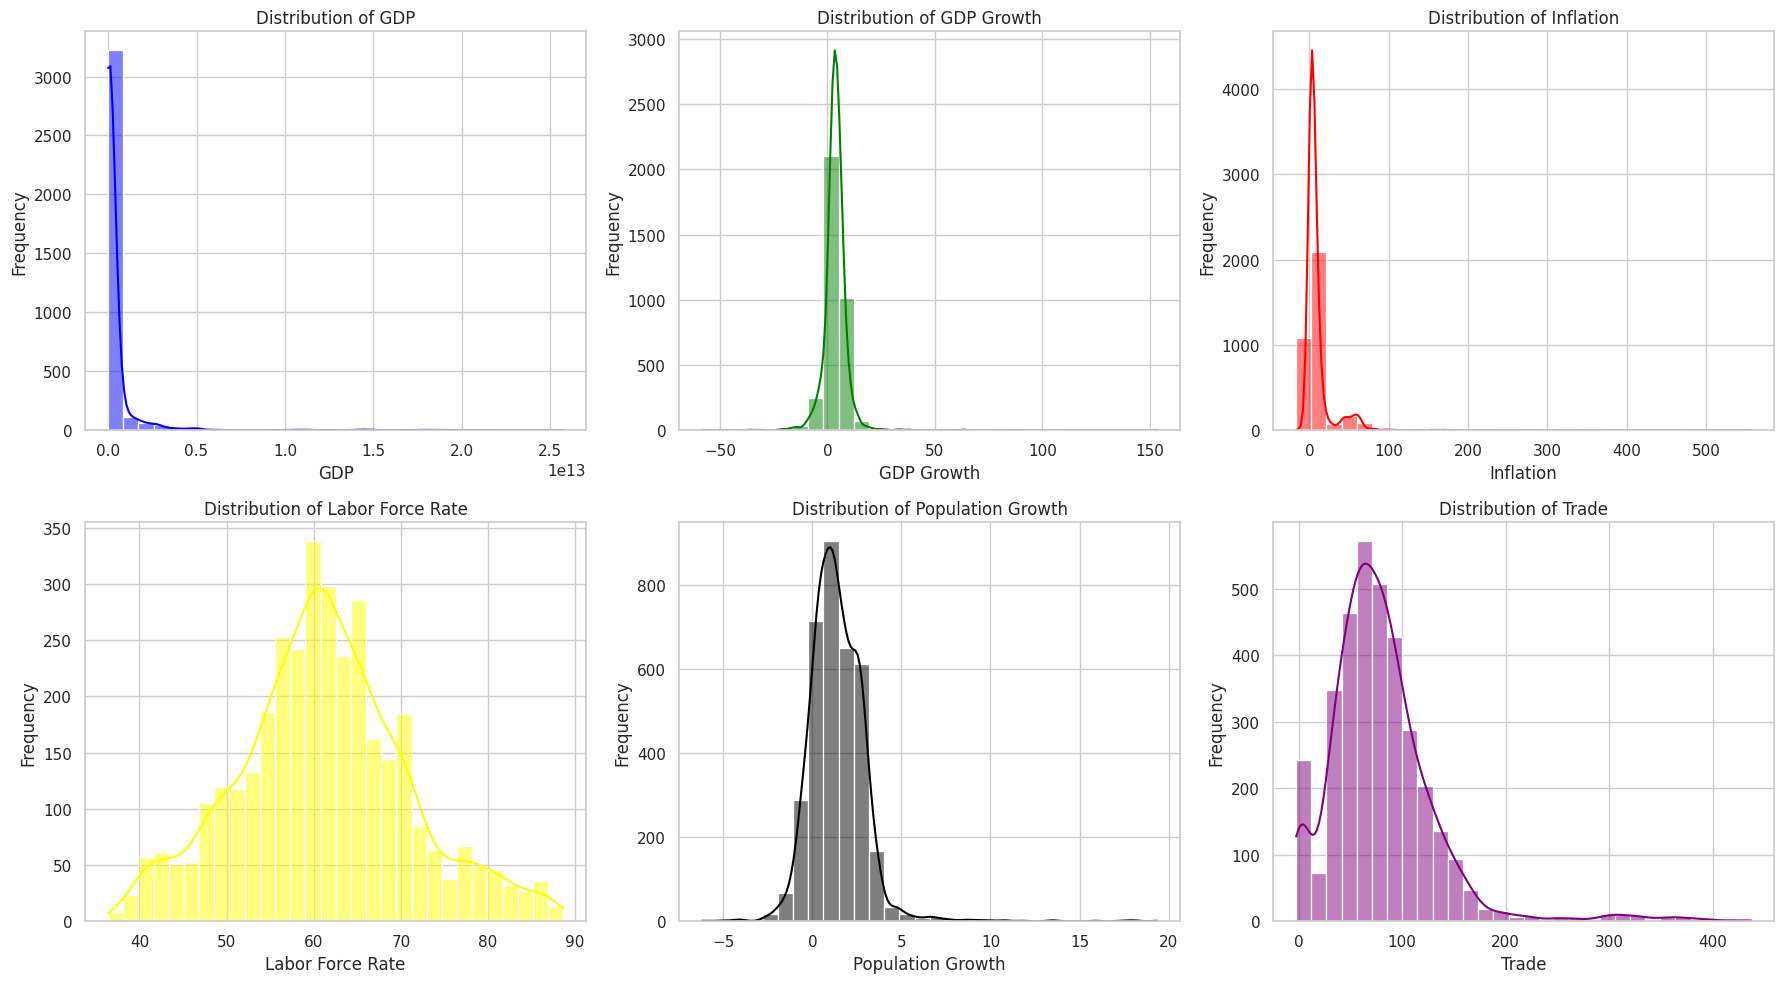

In [100]:
# Check basic statistics and data types
print(filtered_main_df.info())
print(filtered_main_df.describe())

# Select only the required columns for prediction and analysis
df = filtered_main_df[['Country Name', 'Continent', 'Year',
         'Employment to population ratio, 15+, total (%) (modeled ILO estimate)',
         'GDP (current US$)', 'GDP growth (annual %)',
         'Inflation, consumer prices (annual %)',
         'Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate)',
         'Population growth (annual %)', 'Trade (% of GDP)']]

# Rename columns for better readability
df_renamed = df.rename(columns={
    'GDP (current US$)': 'GDP',
    'GDP growth (annual %)': 'GDP Growth',
    'Inflation, consumer prices (annual %)': 'Inflation',
    'Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate)': 'Labor Force Rate',
    'Population growth (annual %)': 'Population Growth',
    'Trade (% of GDP)': 'Trade',
    'Employment to population ratio, 15+, total (%) (modeled ILO estimate)': 'Employment Rate'
})

# **Feature Distribution (Histograms) for Input Features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# List of input features and their respective colors
input_features = ['GDP', 'GDP Growth', 'Inflation', 'Labor Force Rate', 'Population Growth', 'Trade']
colors = ['blue', 'green', 'red', 'yellow', 'black', 'purple']

# Plot histograms with different colors
for i, (feature, color) in enumerate(zip(input_features, colors)):
    sns.histplot(df_renamed[feature], ax=axes[i//3, i%3], kde=True, bins=30, color=color)
    axes[i//3, i%3].set_title(f'Distribution of {feature}')
    axes[i//3, i%3].set_xlabel(feature)
    axes[i//3, i%3].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


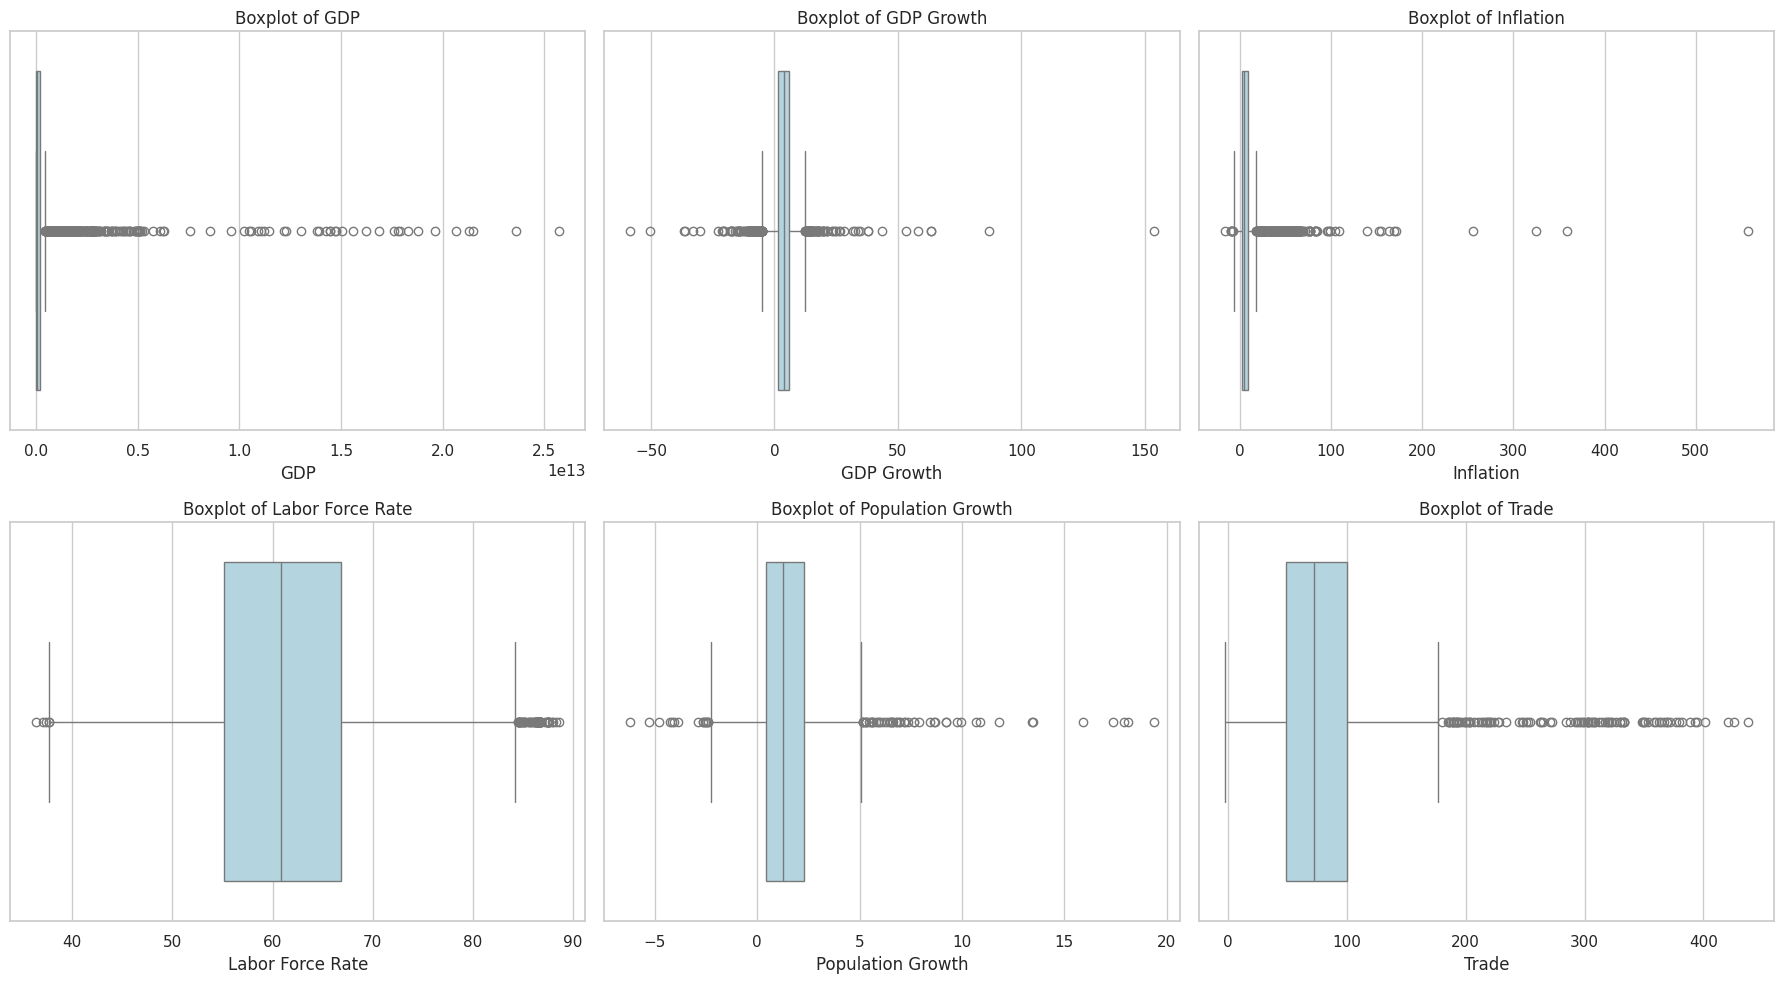

In [101]:
# Check for outliers using boxplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, feature in enumerate(input_features):
    sns.boxplot(x=df_renamed[feature], ax=axes[i//3, i%3], color='lightblue')
    axes[i//3, i%3].set_title(f'Boxplot of {feature}')
    axes[i//3, i%3].set_xlabel(feature)

plt.tight_layout()
plt.show()


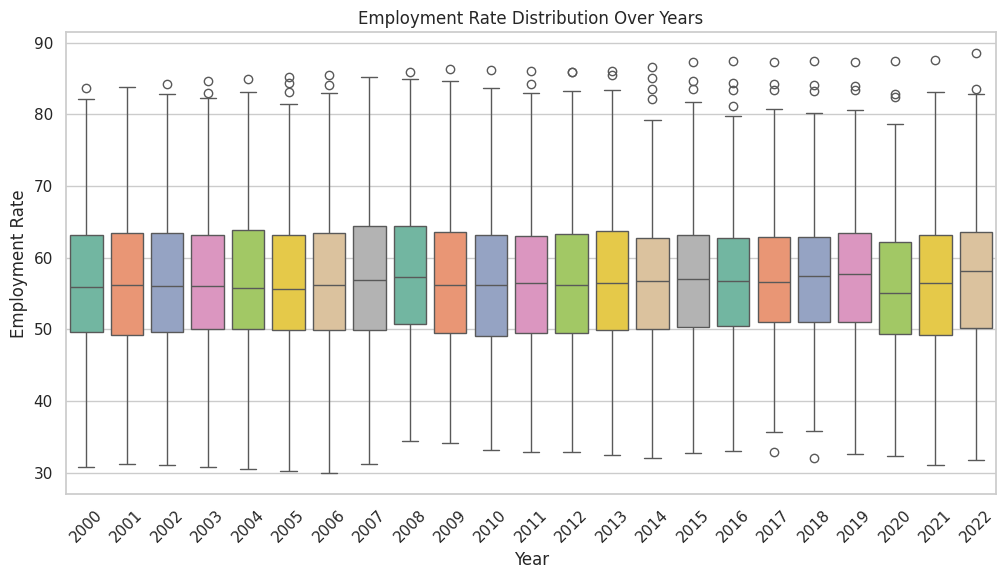

In [102]:
# Boxplot for employment rate over years
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='Employment Rate', data=df_renamed, palette="Set2")
plt.title('Employment Rate Distribution Over Years')
plt.xlabel('Year')
plt.ylabel('Employment Rate')
plt.xticks(rotation=45)
plt.show()


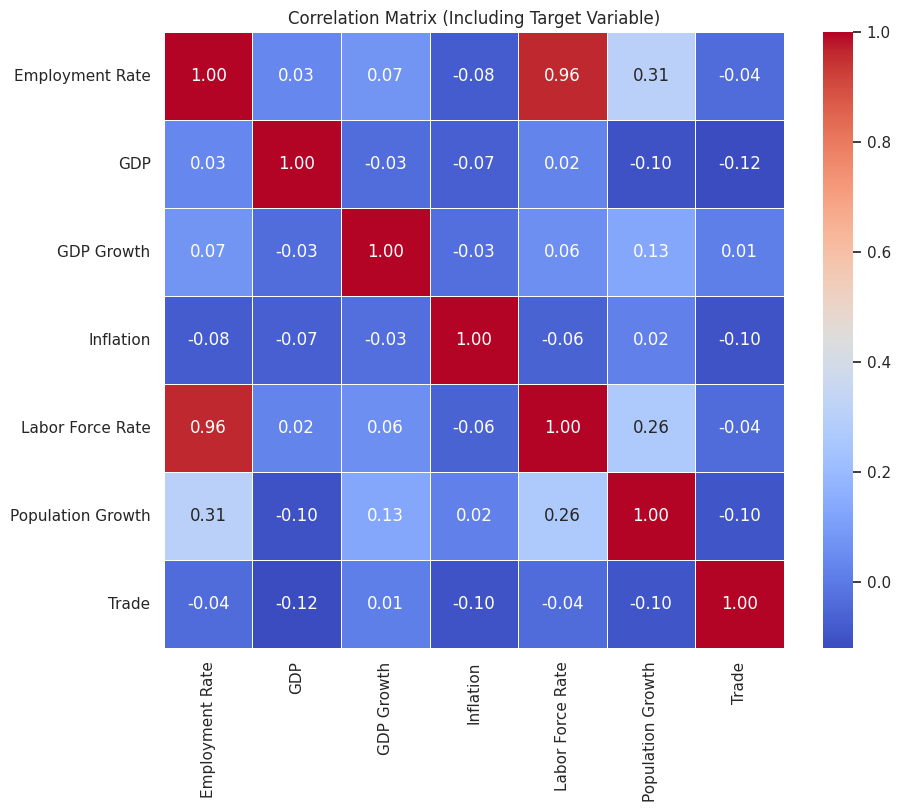

In [103]:
# Calculate correlation matrix including the target variable
correlation_matrix = df_renamed[['Employment Rate', 'GDP', 'GDP Growth', 'Inflation', 'Labor Force Rate', 'Population Growth', 'Trade']].corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix (Including Target Variable)')
plt.show()


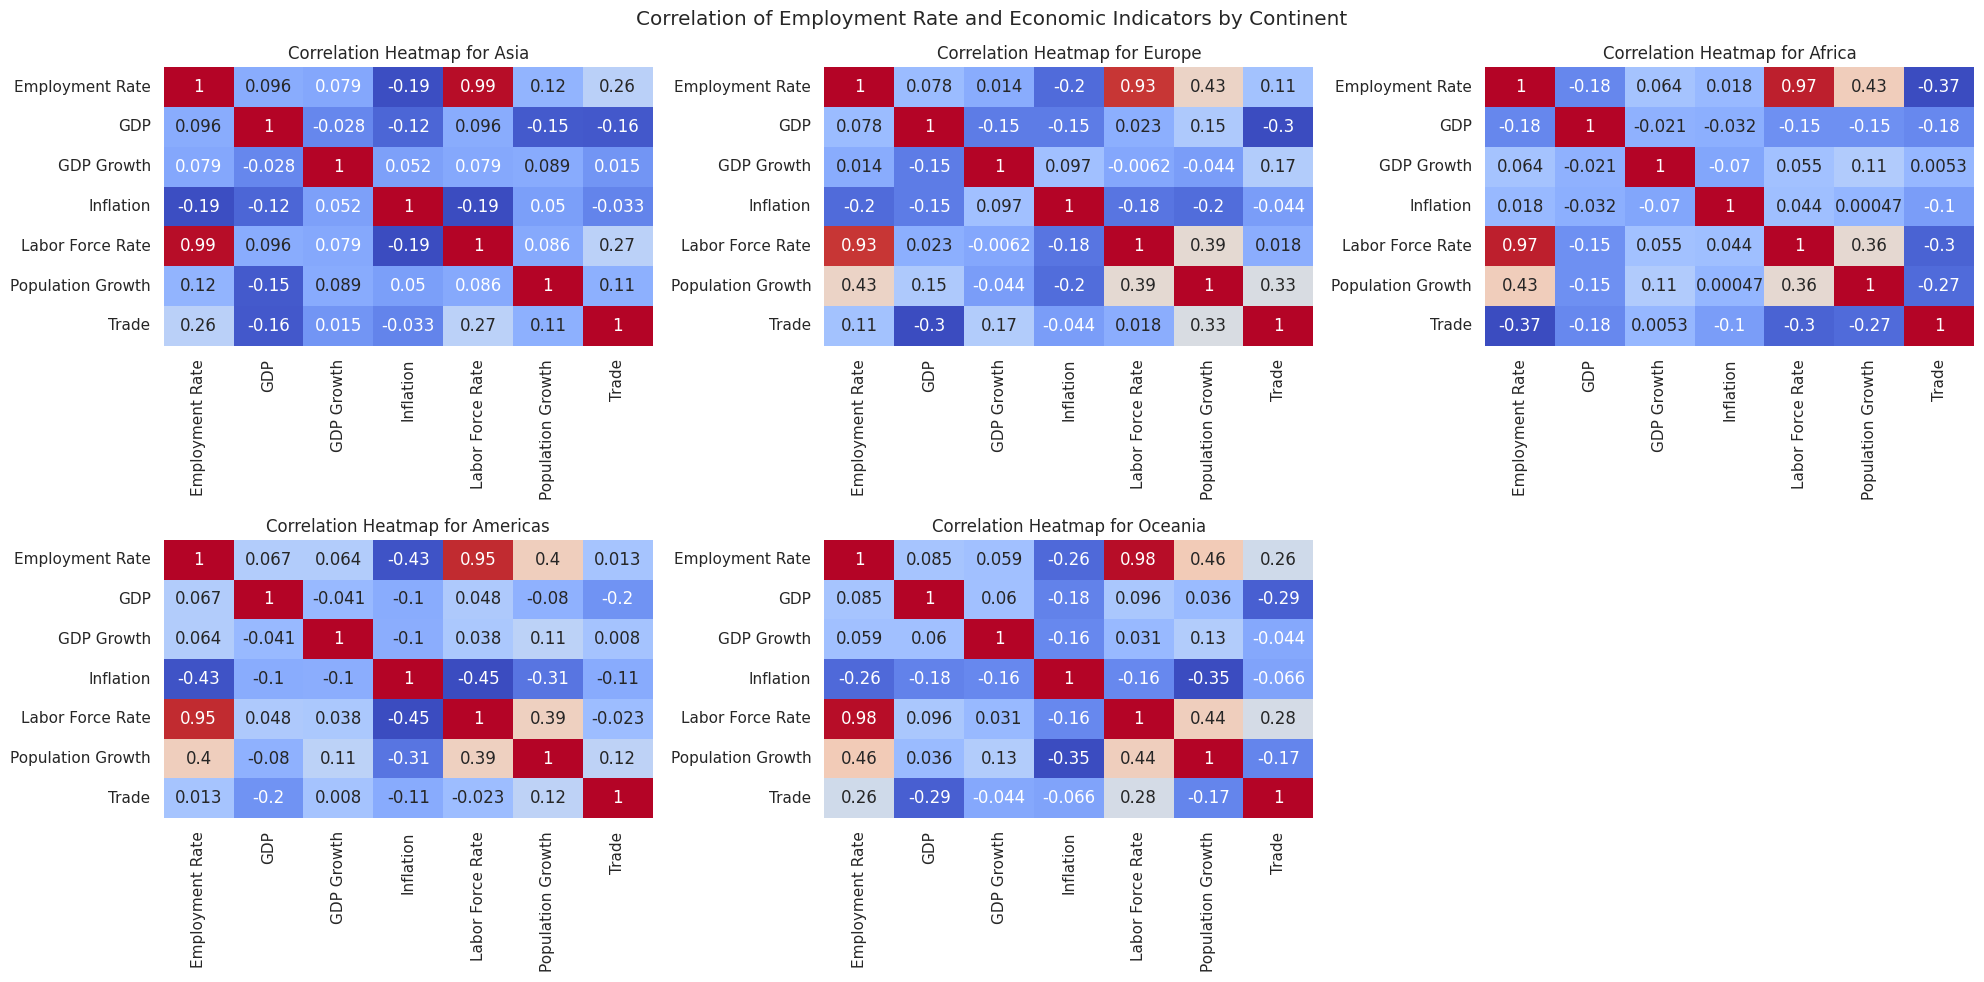

In [104]:
# Set up the heatmap for each continent
plt.figure(figsize=(20, 10))

# Loop over each continent to create individual heatmaps
for i, continent in enumerate(df_renamed['Continent'].unique(), 1):
    plt.subplot(2, 3, i)
    subset = df_renamed[df_renamed['Continent'] == continent]
    corr = subset[['Employment Rate', 'GDP', 'GDP Growth', 'Inflation',
                   'Labor Force Rate', 'Population Growth', 'Trade']].corr()
    sns.heatmap(corr, annot=True, cmap="coolwarm", cbar=False)
    plt.title(f'Correlation Heatmap for {continent}')

plt.suptitle("Correlation of Employment Rate and Economic Indicators by Continent")
plt.tight_layout()
plt.show()


<Figure size 2000x1200 with 0 Axes>

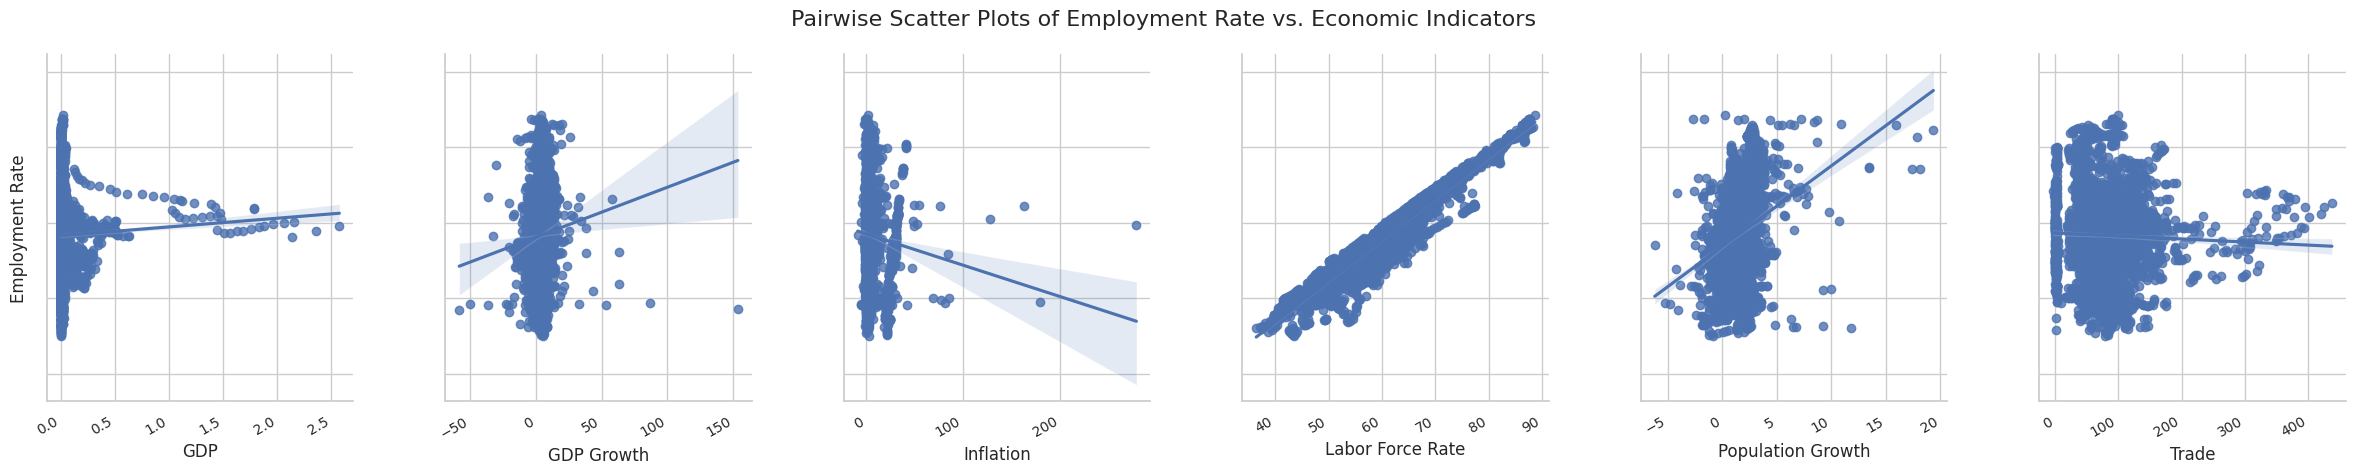

In [105]:
# Set the style for the plots
sns.set(style="whitegrid")

# Plotting with renamed columns
sns.set(style="whitegrid")
plt.figure(figsize=(20, 12))

# Pairwise scatter plots with trend lines
g = sns.pairplot(
    df_renamed,
    x_vars=['GDP', 'GDP Growth', 'Inflation', 'Labor Force Rate', 'Population Growth', 'Trade'],
    y_vars=['Employment Rate'],
    kind="reg",
    height=4.5,
    aspect=0.9
)

# Rotate x-axis labels and adjust y-axis label positions
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

# Adjust subplot parameters for better spacing
g.fig.subplots_adjust(top=0.92, bottom=0.15, hspace=0.4, wspace=0.3)
g.fig.suptitle("Pairwise Scatter Plots of Employment Rate vs. Economic Indicators", y=1.02, fontsize=16)

plt.show()


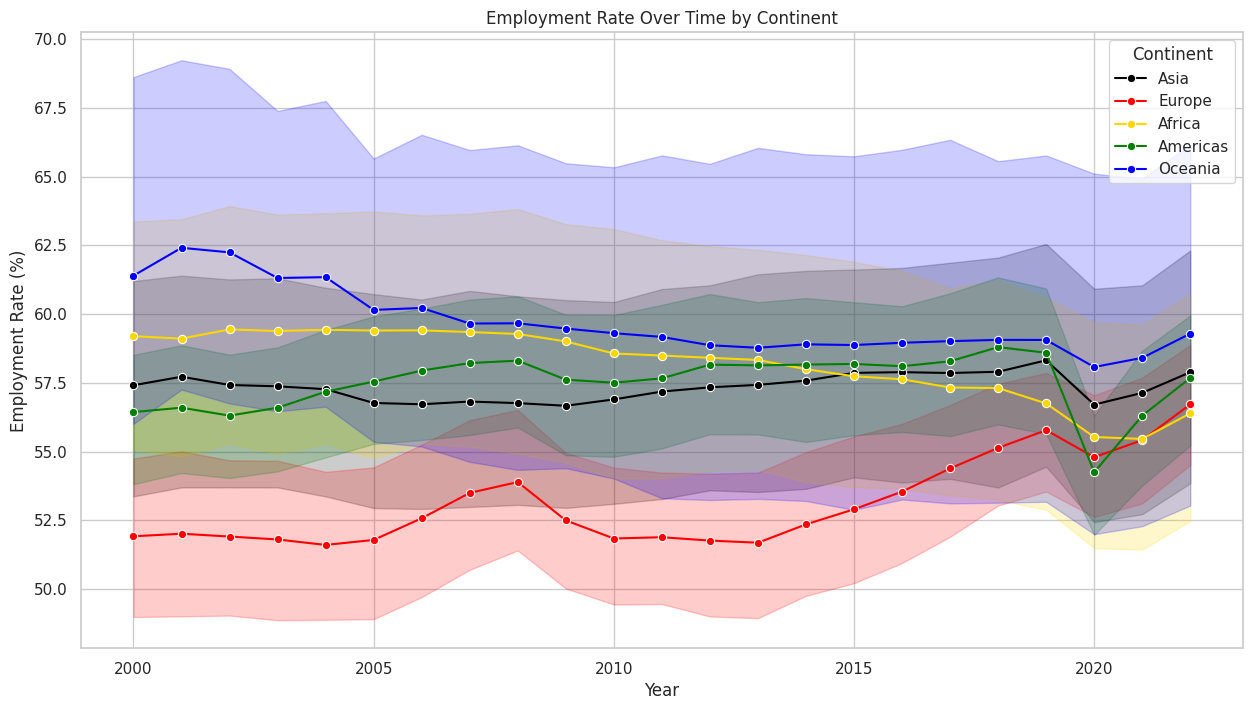

In [106]:
# Group by Continent and Year, and calculate the mean of selected features
continent_time_series = df_renamed.groupby(['Continent', 'Year']).agg({
    'Employment Rate': 'mean',
    'GDP': 'mean',
    'Inflation': 'mean',
    'Labor Force Rate': 'mean',
    'Population Growth': 'mean',
    'Trade': 'mean'
}).reset_index()

# Plot time series for each continent
continents = continent_time_series['Continent'].unique()


# Plot using seaborn's lineplot with hue to distinguish continents
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_renamed, x='Year', y='Employment Rate', hue='Continent', marker='o', palette=['black', 'red', 'gold', 'green', 'blue'])
plt.title('Employment Rate Over Time by Continent')
plt.xlabel('Year')
plt.ylabel('Employment Rate (%)')
plt.legend(title='Continent')
plt.grid(True)
plt.show()



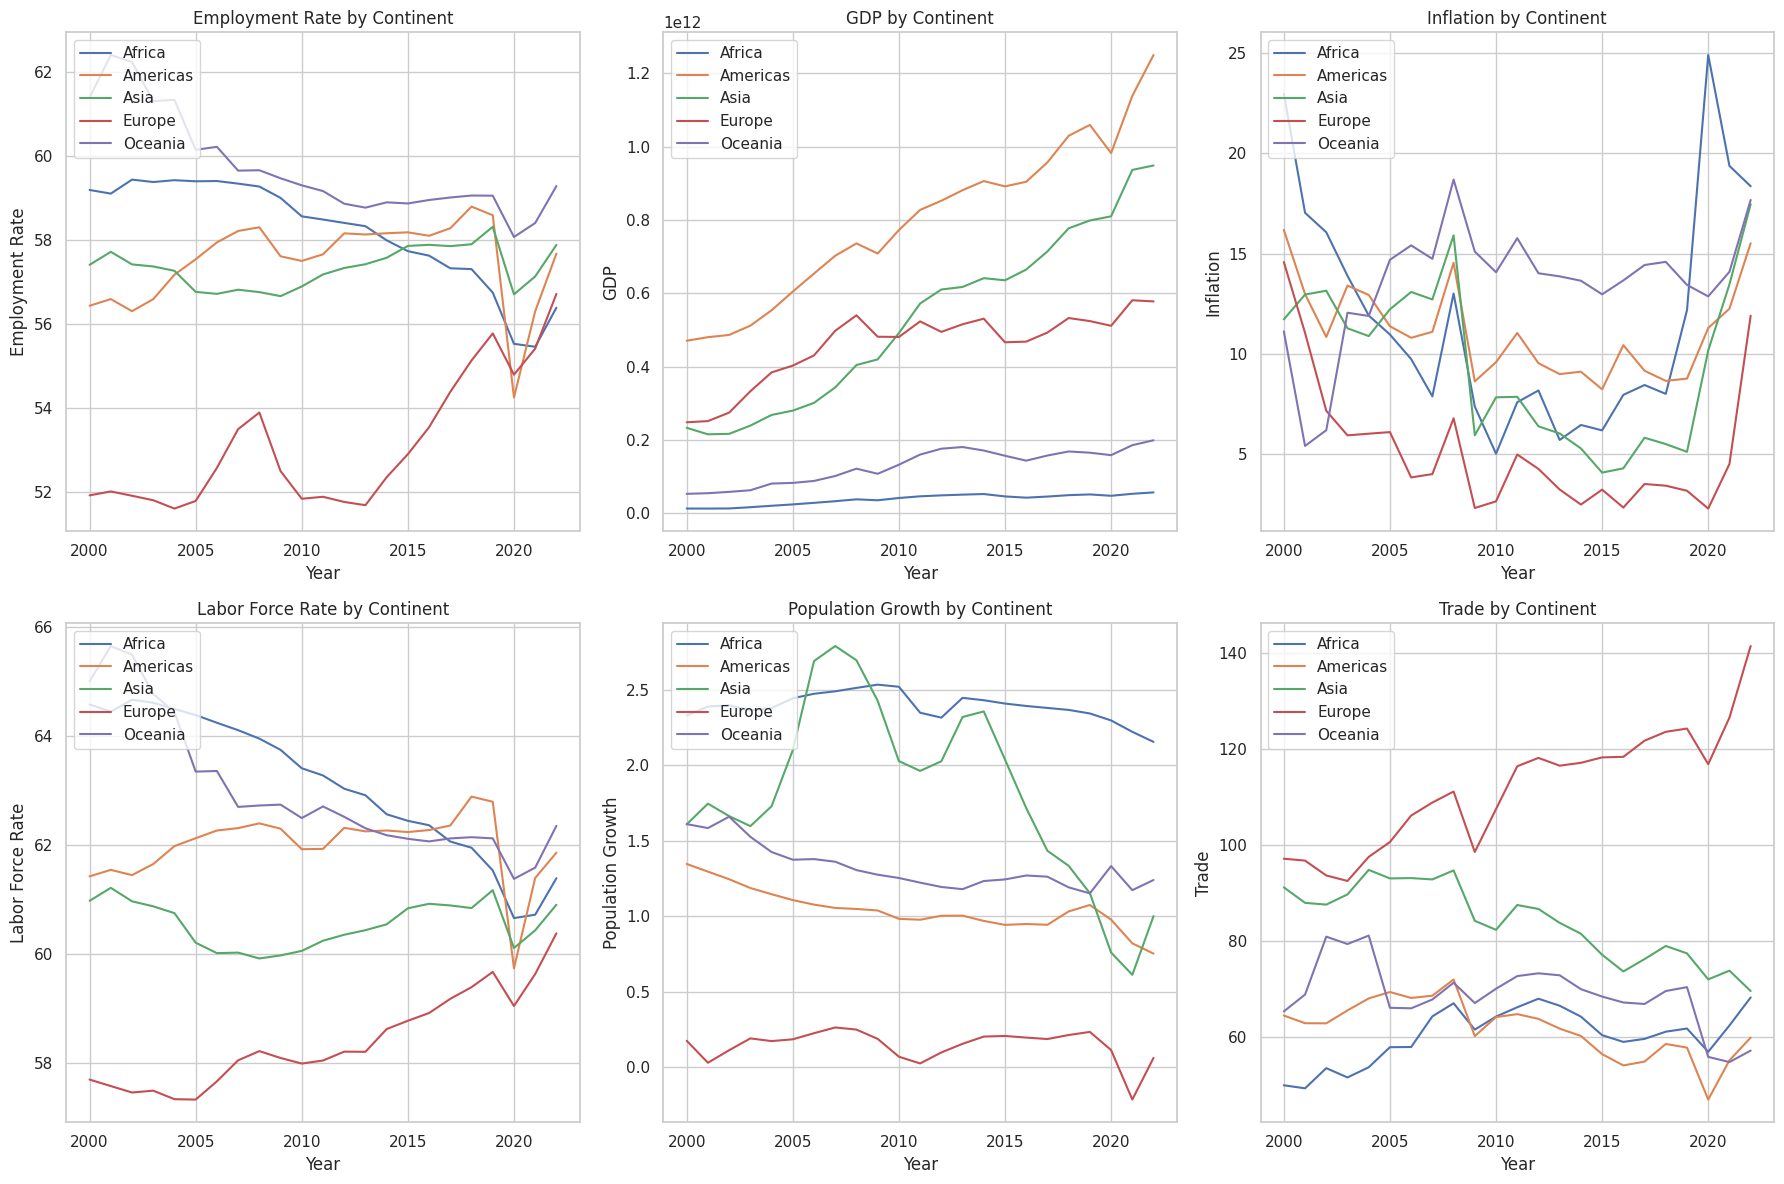

In [107]:
# Create subplots for different features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Features to plot
features = ['Employment Rate', 'GDP', 'Inflation', 'Labor Force Rate', 'Population Growth', 'Trade']

# Loop through features and plot for each continent
for i, feature in enumerate(features):
    ax = axes[i//3, i%3]

    for continent in continents:
        continent_data = continent_time_series[continent_time_series['Continent'] == continent]
        ax.plot(continent_data['Year'], continent_data[feature], label=f'{continent}')

    ax.set_title(f'{feature} by Continent')
    ax.set_xlabel('Year')
    ax.set_ylabel(feature)
    ax.legend(loc='upper left')
    ax.grid(True)

plt.tight_layout()
plt.show()


In [108]:
# Select numeric features for scaling
numeric_features = ['GDP', 'GDP Growth', 'Inflation', 'Labor Force Rate', 'Population Growth', 'Trade']

# Initialize the scaler
scaler = StandardScaler()

# Scale the numeric features
df_renamed[numeric_features] = scaler.fit_transform(df_renamed[numeric_features])

# Check the scaled values
print(df_renamed.head())


  Country Name Continent  Year  Employment Rate       GDP  GDP Growth  \
5  Afghanistan      Asia  2005           43.311 -0.236663    1.230864   
6  Afghanistan      Asia  2006           43.259 -0.236202    0.272020   
7  Afghanistan      Asia  2007           43.216 -0.234537    1.654843   
8  Afghanistan      Asia  2008           43.178 -0.234321    0.038131   
9  Afghanistan      Asia  2009           43.153 -0.232937    2.889944   

   Inflation  Labor Force Rate  Population Growth     Trade  
5   0.151142         -1.442052           1.381362 -1.441126  
6  -0.135433         -1.447786           1.736699 -1.430416  
7  -0.043368         -1.452700           0.256165 -1.475040  
8   0.817964         -1.456693           0.388122 -1.471062  
9  -0.795620         -1.459663           1.371759 -1.441415  


In [109]:
# Split data into training and testing based on the year
train_df = df_renamed[df_renamed['Year'] <= 2020]
test_df = df_renamed[df_renamed['Year'] > 2020]

# Separate the features (X) and target variable (y)
X_train = train_df[['GDP', 'GDP Growth', 'Inflation', 'Labor Force Rate', 'Population Growth', 'Trade']]
y_train = train_df['Employment Rate']

X_test = test_df[['GDP', 'GDP Growth', 'Inflation', 'Labor Force Rate', 'Population Growth', 'Trade']]
y_test = test_df['Employment Rate']

# Check the shape of the datasets
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (3214, 6)
Testing data shape: (301, 6)


In [110]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify the transformation
print("Scaled Training Data:\n", X_train_scaled[:5])
print("Scaled Testing Data:\n", X_test_scaled[:5])

Scaled Training Data:
 [[-0.24067767  1.39292029  0.18211442 -1.44326444  1.34469894 -1.45191028]
 [-0.24018498  0.33108941 -0.12007395 -1.44899313  1.69664141 -1.44108637]
 [-0.2384052   1.86243813 -0.02299276 -1.45390344  0.23025166 -1.48618486]
 [-0.2381735   0.07207946  0.88526601 -1.45789307  0.3609482  -1.48216532]
 [-0.23669457  3.23019772 -0.81622917 -1.46085971  1.33518772 -1.4522028 ]]
Scaled Testing Data:
 [[-0.23550831 -4.38763092  1.64432917 -2.03618424  0.89152994 -0.53253583]
 [-0.23535723 -1.76598314  1.45984167 -2.4047643   0.69351469 -0.11981848]
 [-0.23315928  0.97320345 -0.36294024 -0.24729732 -1.46963203 -0.05961279]
 [-0.23252727  0.24049835 -0.12311515 -0.08474564 -1.65015728  0.11589497]
 [-0.12523968  0.04947989 -0.09746917 -2.17735562  0.14557816 -0.61212068]]


In [111]:
# Initialize and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = linear_model.predict(X_test_scaled)

# Evaluate the model's performance
mae_LR = mean_absolute_error(y_test, y_pred)
mse_LR = mean_squared_error(y_test, y_pred)
r2_LR = r2_score(y_test, y_pred)

print(f"Linear Regression Model Performance:\nMAE(LR): {mae_LR}\nMSE(LR): {mse_LR}\nR^2(LR): {r2_LR}")


Linear Regression Model Performance:
MAE(LR): 2.089180684153082
MSE(LR): 7.972700638514107
R^2(LR): 0.9314302442018243


In [112]:
# Reshape data into 3D array for LSTM: (samples, timesteps, features)
def reshape_for_lstm(X):
    return X.reshape((X.shape[0], 1, X.shape[1]))

# Scale the features for LSTM (scaling between 0 and 1)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_lstm = reshape_for_lstm(X_train_scaled)
X_test_lstm = reshape_for_lstm(X_test_scaled)

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=1)

# Predict with the model
y_pred_lstm = model.predict(X_test_lstm)

# Evaluate performance
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f"LSTM Model Performance:")
print(f"MAE: {mae_lstm}")
print(f"MSE: {mse_lstm}")
print(f"R^2: {r2_lstm}")


Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3320.5737
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3117.4878
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2637.9595
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2019.6462
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1464.2115
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1057.4224
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 768.5307
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 548.3926
Epoch 9/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 399.9106
Epoch 10/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 297.0717
Epoch 11/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 224.6230
Epoch 12/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 168.6542
Epoch 13/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 143.7172
Epoch 14/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 118.0715
Epoch 15/20
101/101 ━━━

In [113]:
# Train XGBoost model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=10)

xg_reg.fit(X_train_scaled, y_train)

# Predict with the model
y_pred_xgb = xg_reg.predict(X_test_scaled)

# Evaluate performance
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Model Performance:")
print(f"MAE: {mae_xgb}")
print(f"MSE: {mse_xgb}")
print(f"R^2: {r2_xgb}")

XGBoost Model Performance:
MAE: 6.694024180364767
MSE: 76.1079100227167
R^2: 0.3454287272048093


In [114]:
# Filter data for 2000 to 2020 for training
train_data = df_renamed[(df_renamed['Year'] >= 2000) & (df_renamed['Year'] <= 2020)]

# Filter data for 2021 and 2022 for testing
test_data_2021_2022 = df_renamed[(df_renamed['Year'] == 2021) | (df_renamed['Year'] == 2022)]

# Separate features and target for training
X_train = train_data[['GDP', 'GDP Growth', 'Inflation', 'Labor Force Rate', 'Population Growth', 'Trade']]
y_train = train_data['Employment Rate']

# Separate features for testing
X_test_2021_2022 = test_data_2021_2022[['GDP', 'GDP Growth', 'Inflation', 'Labor Force Rate', 'Population Growth', 'Trade']]

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=250, random_state=42)

# Train the model on the data from 2000 to 2020
rf_model.fit(X_train, y_train)

# Predict for 2021 and 2022
predictions_2021_2022 = rf_model.predict(X_test_2021_2022)

# Add predictions to the actual data for comparison
test_data_2021_2022['Predicted Employment Rate'] = predictions_2021_2022

# Evaluate model performance (for 2021 and 2022 only)
mae_rf = mean_absolute_error(test_data_2021_2022['Employment Rate'], predictions_2021_2022)
mse_rf = mean_squared_error(test_data_2021_2022['Employment Rate'], predictions_2021_2022)
r2_rf = r2_score(test_data_2021_2022['Employment Rate'], predictions_2021_2022)

print(f"Model Performance for 2021-2022:")
print(f"MAE: {mae_rf:.2f}")
print(f"MSE: {mse_rf:.2f}")
print(f"R^2: {r2_rf:.2f}")

# Save the trained model to a file
joblib.dump(rf_model, 'best_rf_model.pkl')
print("Model saved as 'best_rf_model.pkl'")

Model Performance for 2021-2022:
MAE: 1.70
MSE: 5.90
R^2: 0.95
Model saved as 'best_rf_model.pkl'


In [115]:
# Define the parameter grid with a smaller range
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500], # Number of trees in the forest
    'max_depth': [10, 20, 30, None],  # # Max depth of the tree
    'min_samples_split': [2, 5, 10],  # Regularization
    'min_samples_leaf': [1, 2, 4],  # Regularization
    'max_features': ['auto', 'sqrt', 'log2']  # Consider 'log2' for experimentation
}


# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV with fewer iterations
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist,
                                   n_iter=10, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)

# Fit RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_

# Print the best hyperparameters found
print(f"Best Hyperparameters: {best_params}")

# Train the model with the best hyperparameters
best_rf_model = random_search.best_estimator_

# Predict on the test set
predictions = best_rf_model.predict(X_test)

# Evaluate the model performance
mae_hyper = mean_absolute_error(y_test, predictions)
mse_hyper = mean_squared_error(y_test, predictions)
r2_hyper = r2_score(y_test, predictions)

print(f"MAE: {mae_hyper}")
print(f"MSE: {mse_hyper}")
print(f"R^2: {r2_hyper}")


Best Hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}
MAE: 1.9190814921999408
MSE: 7.430413222958739
R^2: 0.9360942241181687


Best Hyperparameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}


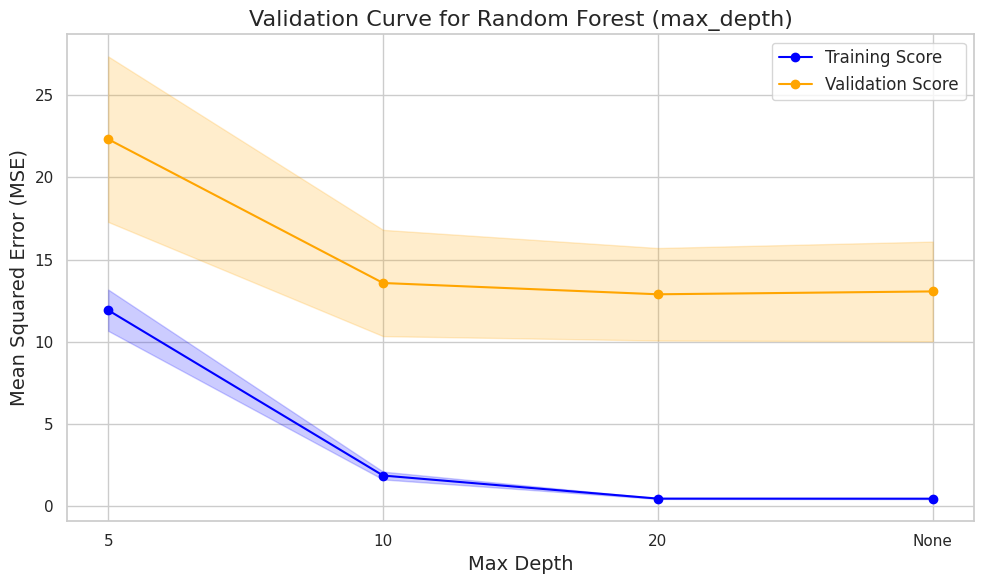

In [116]:
from sklearn.model_selection import validation_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Get the best parameters from RandomizedSearchCV
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

# Define parameter range for validation curve (e.g., max_depth)
param_range = [5, 10, 20, None]  # None means unlimited depth

# Compute the validation curve for max_depth
train_scores, test_scores = validation_curve(
    RandomForestRegressor(
        n_estimators=best_params['n_estimators'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        random_state=42
    ),
    X_train, y_train,
    param_name="max_depth",
    param_range=param_range,
    scoring="neg_mean_squared_error",  # Using negative MSE as the scoring metric
    cv=3,  # 3-fold cross-validation
    n_jobs=-1
)

# Calculate mean and standard deviation for training and validation scores
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot([str(p) for p in param_range], train_mean, label="Training Score", color="blue", marker='o')
plt.plot([str(p) for p in param_range], test_mean, label="Validation Score", color="orange", marker='o')

# Fill areas between the scores with standard deviations
plt.fill_between([str(p) for p in param_range], train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.fill_between([str(p) for p in param_range], test_mean - test_std, test_mean + test_std, color="orange", alpha=0.2)

# Add labels, title, and legend
plt.title("Validation Curve for Random Forest (max_depth)", fontsize=16)
plt.xlabel("Max Depth", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


Model Performance Summary:
                     Model       MAE        MSE        R2  Accuracy (%)
0        Linear Regression  2.089181   7.972701  0.931430          93.1
1                     LSTM  7.012646  85.935267  0.260908          26.1
2                  XGBoost  6.694024  76.107910  0.345429          34.5
3  Random Forest (Default)  1.703511   5.900785  0.949250          94.9
4    Random Forest (Tuned)  1.919081   7.430413  0.936094          93.6


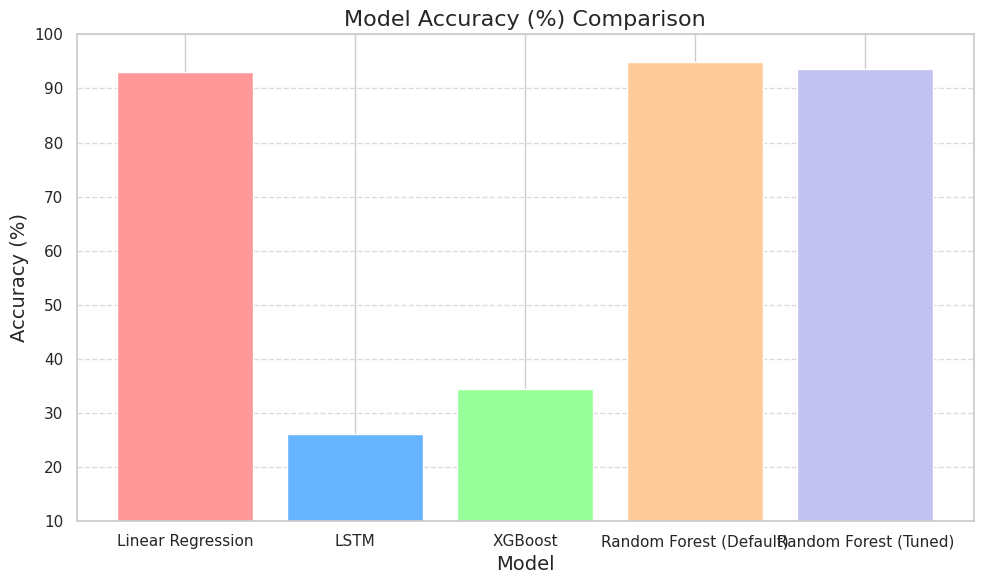

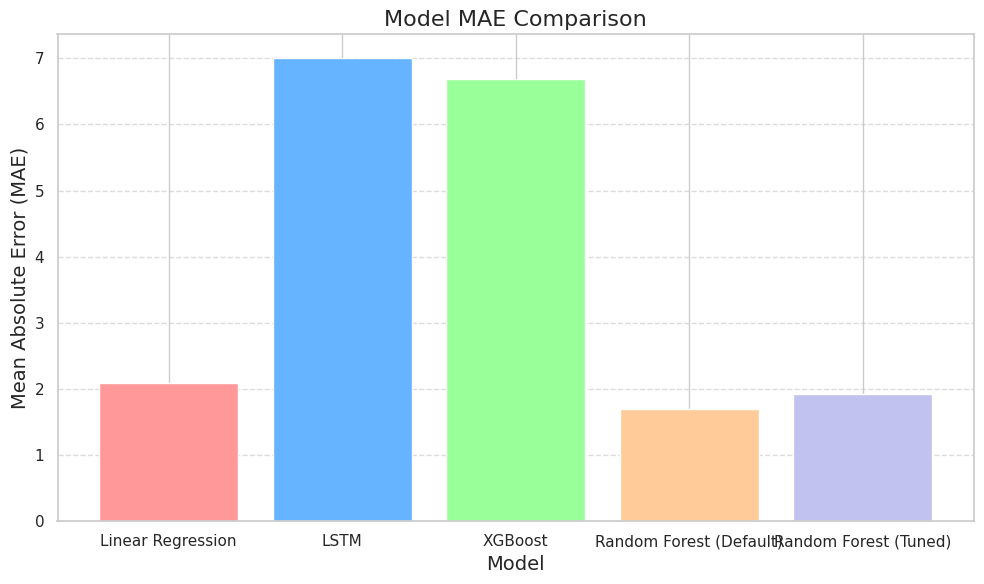

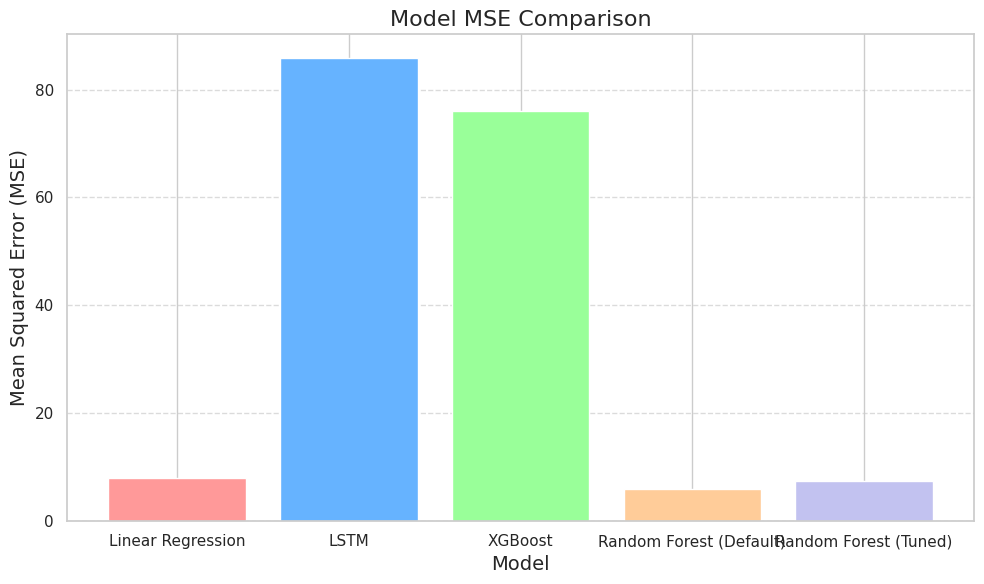

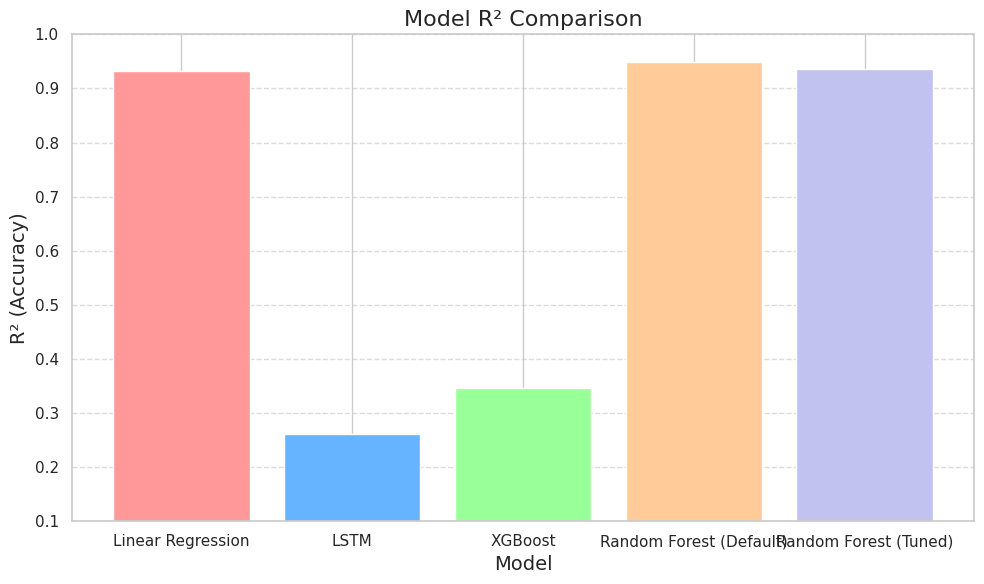

In [117]:
import pandas as pd
import matplotlib.pyplot as plt

# Accuracy calculation: Accuracy (%) = R² * 100
accuracy_LR = round(r2_LR * 100, 1)
accuracy_lstm = round(r2_lstm * 100, 1)
accuracy_xgb = round(r2_xgb * 100, 1)
accuracy_rf = round(r2_rf * 100, 1)
accuracy_hyper = round(r2_hyper * 100, 1)

# Consolidate metrics for all models
model_metrics = pd.DataFrame({
    'Model': ['Linear Regression', 'LSTM', 'XGBoost', 'Random Forest (Default)', 'Random Forest (Tuned)'],
    'MAE': [mae_LR, mae_lstm, mae_xgb, mae_rf, mae_hyper],
    'MSE': [mse_LR, mse_lstm, mse_xgb, mse_rf, mse_hyper],
    'R2': [r2_LR, r2_lstm, r2_xgb, r2_rf, r2_hyper],
    'Accuracy (%)': [accuracy_LR, accuracy_lstm, accuracy_xgb, accuracy_rf, accuracy_hyper]
})

# Print the metrics summary
print("Model Performance Summary:")
print(model_metrics)


# Plot Accuracy (%) Comparison
plt.figure(figsize=(10, 6))
plt.bar(model_metrics['Model'], model_metrics['Accuracy (%)'], color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0'])
plt.title('Model Accuracy (%) Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.ylim(10, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot MAE Comparison
plt.figure(figsize=(10, 6))
plt.bar(model_metrics['Model'], model_metrics['MAE'], color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0'])
plt.title('Model MAE Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot MSE Comparison
plt.figure(figsize=(10, 6))
plt.bar(model_metrics['Model'], model_metrics['MSE'], color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0'])
plt.title('Model MSE Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot R² Comparison
plt.figure(figsize=(10, 6))
plt.bar(model_metrics['Model'], model_metrics['R2'], color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0'])
plt.title('Model R² Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('R² (Accuracy)', fontsize=14)
plt.ylim(0.1, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



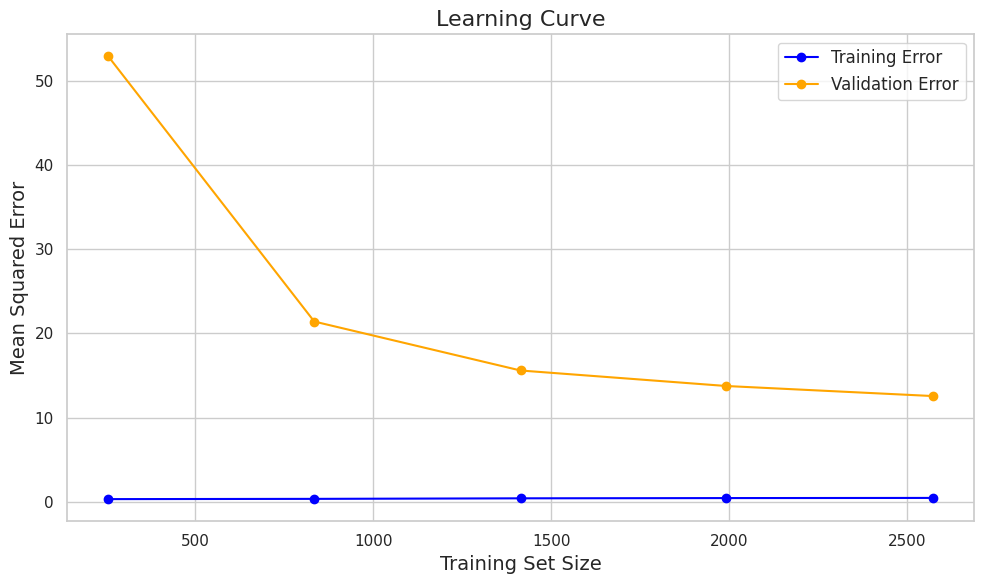

In [118]:
# Finding Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    best_rf_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error", n_jobs=-1
)

train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Error", color="blue", marker="o")
plt.plot(train_sizes, test_mean, label="Validation Error", color="orange", marker="o")
plt.title("Learning Curve", fontsize=16)
plt.xlabel("Training Set Size", fontsize=14)
plt.ylabel("Mean Squared Error", fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


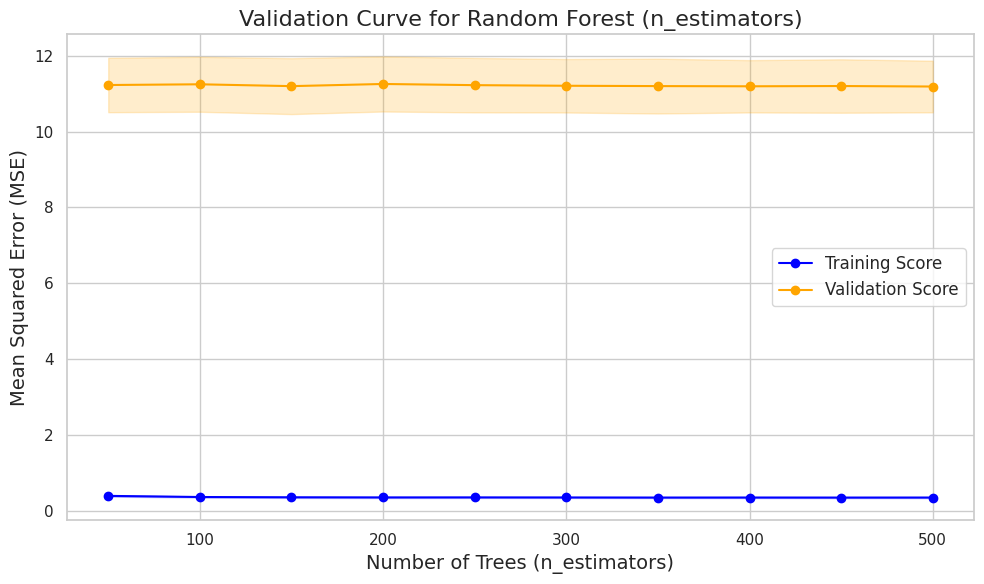

In [119]:

# Define parameter range for n_estimators (number of trees in the forest)
param_range = [50, 100, 150, 200, 250,300, 350, 400, 450, 500]

# Compute the validation curve
train_scores, test_scores = validation_curve(
    RandomForestRegressor(random_state=42),
    X_train, y_train,
    param_name="n_estimators",
    param_range=param_range,
    scoring="neg_mean_squared_error",  # Using negative MSE as the scoring metric
    cv=3,  # 3-fold cross-validation
    n_jobs=-1
)

# Calculate mean and standard deviation for training and validation scores
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training Score", color="blue", marker='o')
plt.plot(param_range, test_mean, label="Validation Score", color="orange", marker='o')

# Fill areas between the scores with standard deviations
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="orange", alpha=0.2)

# Add labels, title, and legend
plt.title("Validation Curve for Random Forest (n_estimators)", fontsize=16)
plt.xlabel("Number of Trees (n_estimators)", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.legend(loc="best", fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [120]:
# Extract relevant columns for the comparison table
comparison_data = test_data_2021_2022[['Country Name', 'Year', 'Employment Rate', 'Predicted Employment Rate']]

# Convert the DataFrame to a tabular format using tabulate
table = tabulate(comparison_data, headers='keys', tablefmt='pretty', showindex=False)

# Print the table
print(table)

+--------------------------+------+-----------------+---------------------------+
|       Country Name       | Year | Employment Rate | Predicted Employment Rate |
+--------------------------+------+-----------------+---------------------------+
|       Afghanistan        | 2021 |     36.263      |     37.39069999999993     |
|       Afghanistan        | 2022 |     32.333      |     32.85161599999994     |
|         Albania          | 2021 |     51.336      |     50.50306800000007     |
|         Albania          | 2022 |     53.304      |     54.64472799999998     |
|         Algeria          | 2021 |      34.39      |     34.34332799999995     |
|         Algeria          | 2022 |     36.593      |     37.19515600000006     |
|          Angola          | 2021 |     64.304      |     65.81773999999989     |
|          Angola          | 2022 |     64.447      |     69.26503999999996     |
|        Argentina         | 2021 |     55.085      |     55.12491200000001     |
|        Argenti

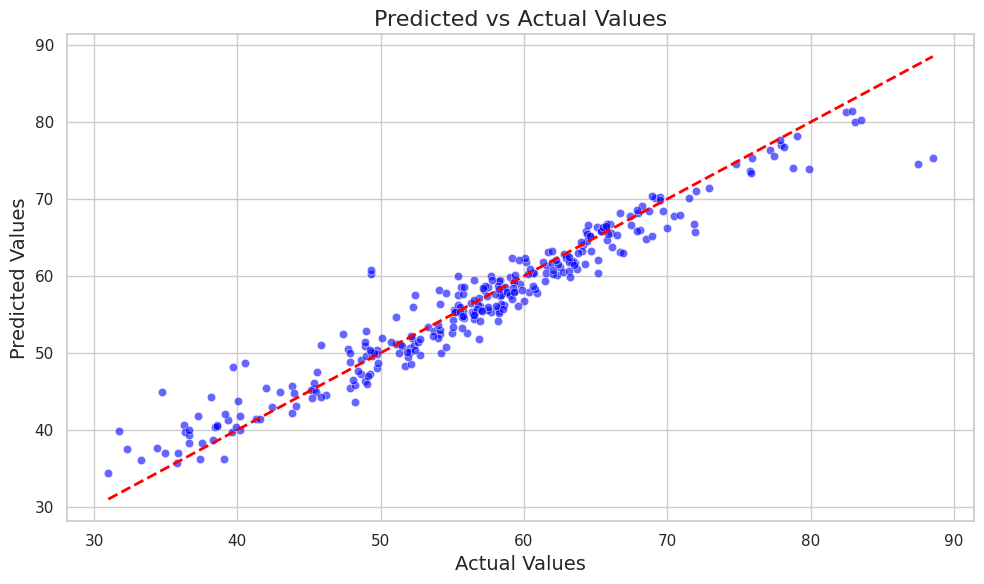

In [121]:
# Finding output how matched with actual value at a glance
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=predictions, color="blue", alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", linewidth=2)
plt.title("Predicted vs Actual Values", fontsize=16)
plt.xlabel("Actual Values", fontsize=14)
plt.ylabel("Predicted Values", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

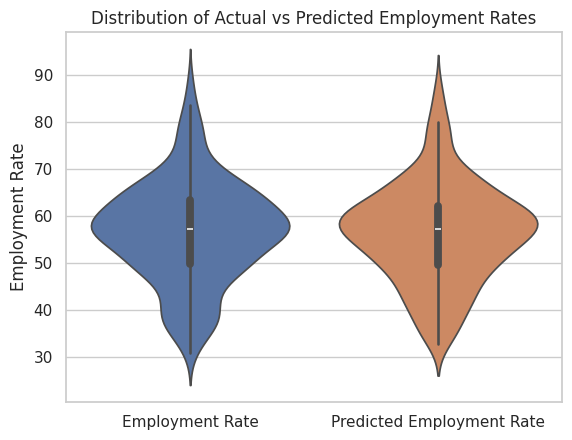

In [122]:
# Plot a violin plot to visualize the distribution of actual (Employment Rate) and predicted values (Predicted Employment Rate)
# This helps compare the spread and central tendencies of the two distributions.
sns.violinplot(data=comparison_data[['Employment Rate', 'Predicted Employment Rate']])
plt.title("Distribution of Actual vs Predicted Employment Rates")
plt.ylabel("Employment Rate")
plt.show()


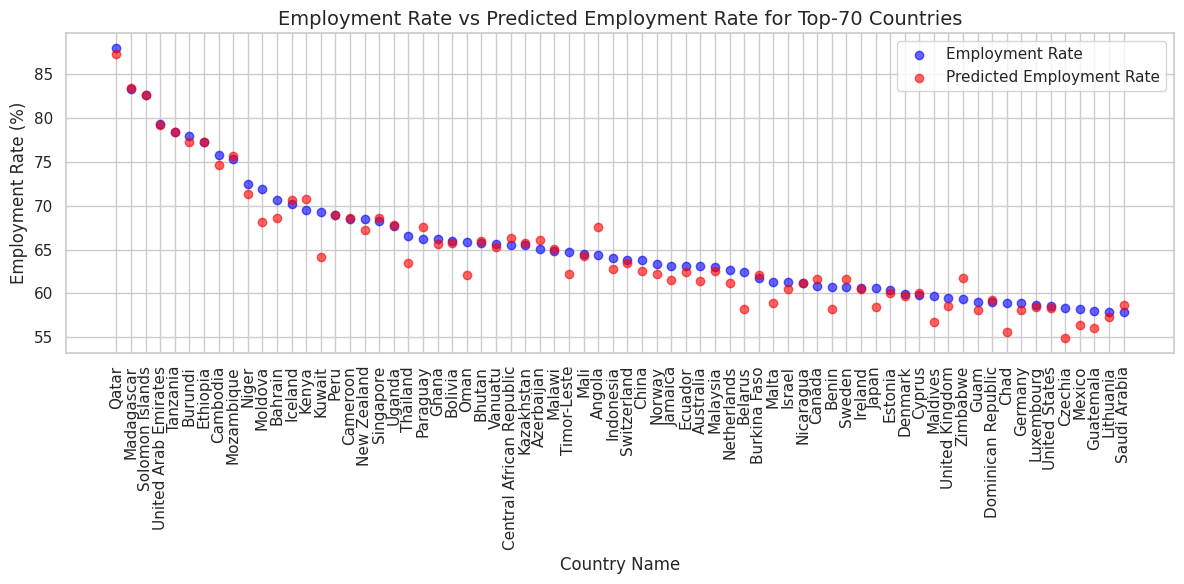

In [123]:
# Set the plot style
sns.set(style="whitegrid")

# Explicitly select only numeric columns when aggregating
top_70_countries = test_data_2021_2022.groupby('Country Name', as_index=False)[
    ['Employment Rate', 'Predicted Employment Rate']
].mean()

# Select the top 50 countries based on Employment Rate
top_70_countries = top_70_countries.nlargest(70, 'Employment Rate')

# Plotting the Actual vs Predicted Employment Rates
plt.figure(figsize=(12, 6))

# Plot actual values
plt.scatter(top_70_countries['Country Name'], top_70_countries['Employment Rate'],
            color='blue', label='Employment Rate', alpha=0.6)

# Plot predicted values
plt.scatter(top_70_countries['Country Name'], top_70_countries['Predicted Employment Rate'],
            color='red', label='Predicted Employment Rate', alpha=0.6)

# Rotate the country names on the x-axis for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Country Name', fontsize=12)
plt.ylabel('Employment Rate (%)', fontsize=12)
plt.title('Employment Rate vs Predicted Employment Rate for Top-70 Countries', fontsize=14)

# Add a legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


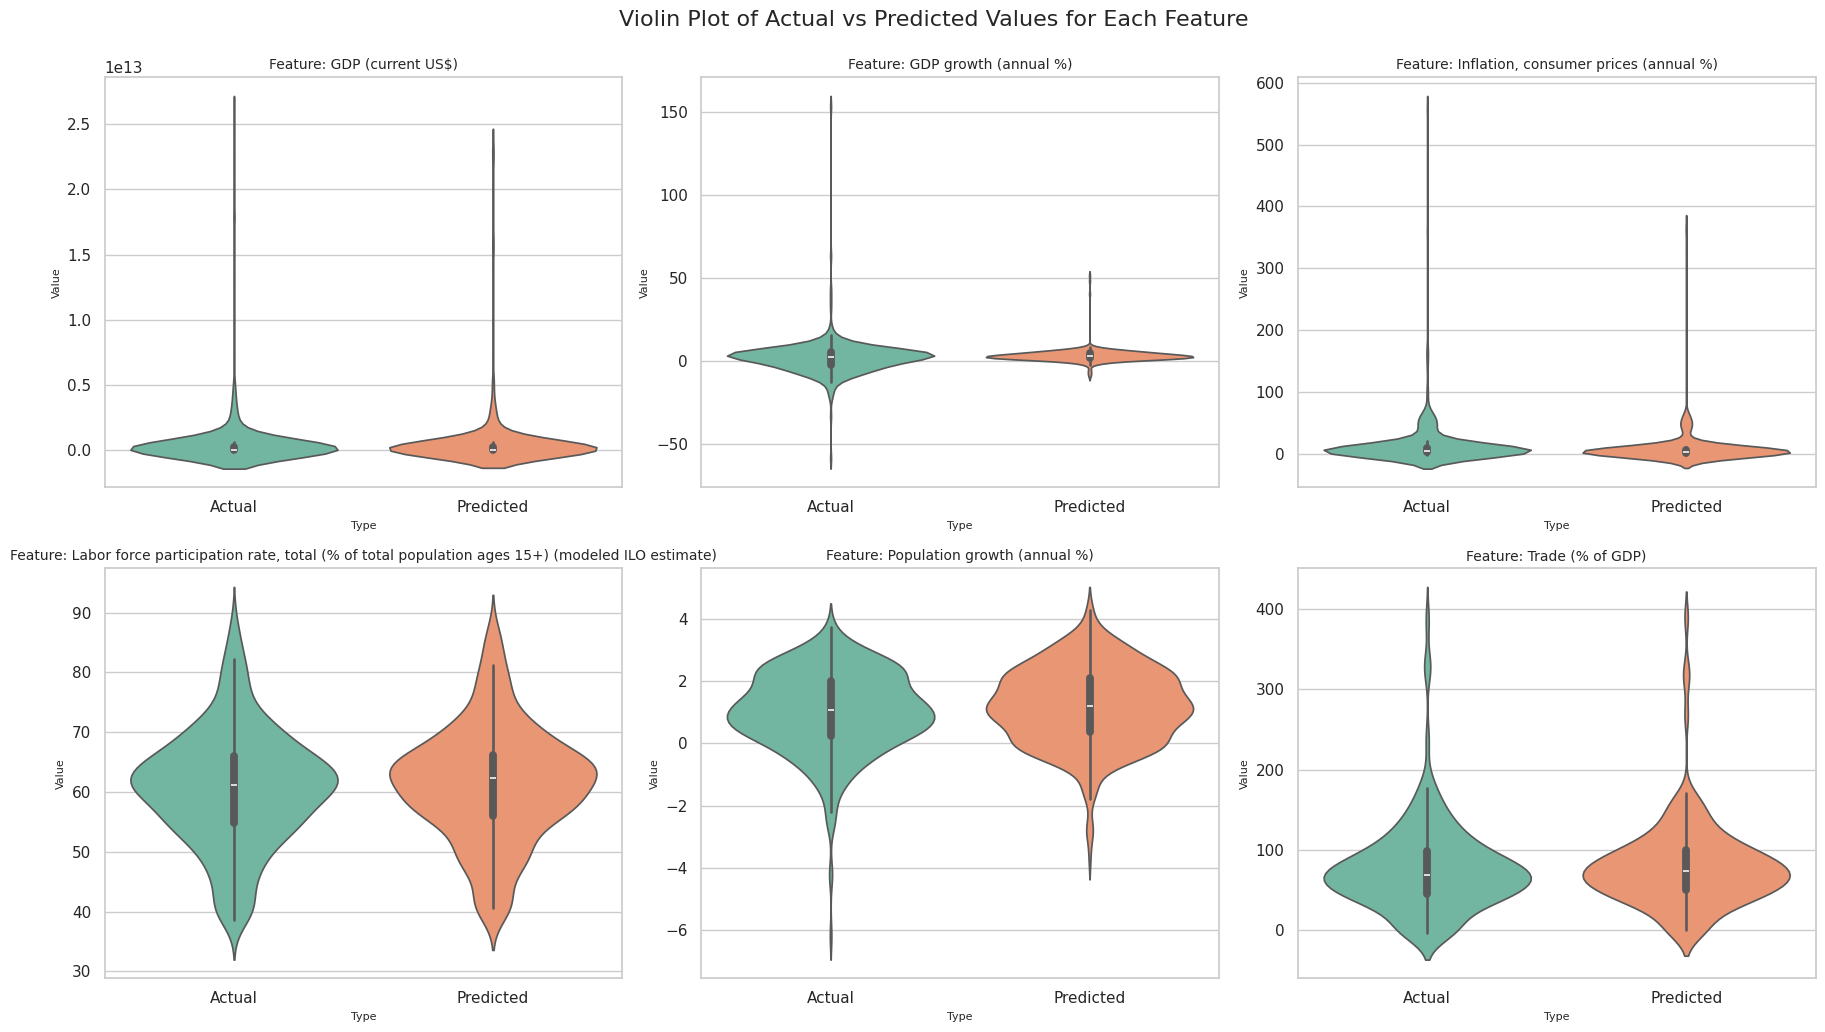

MAPE Results by Continent and Feature:
   Continent                                            Feature        MAPE
0       Asia                                  GDP (current US$)    0.148929
1       Asia                              GDP growth (annual %)    1.139517
2       Asia              Inflation, consumer prices (annual %)    2.850996
3       Asia  Labor force participation rate, total (% of to...    0.024760
4       Asia                       Population growth (annual %)    1.281839
5       Asia                                   Trade (% of GDP)   10.645324
6     Europe                                  GDP (current US$)    0.092992
7     Europe                              GDP growth (annual %)    2.636270
8     Europe              Inflation, consumer prices (annual %)    1.821467
9     Europe  Labor force participation rate, total (% of to...    0.018219
10    Europe                       Population growth (annual %)    0.780401
11    Europe                                   Tr

In [124]:
# This code evaluates ARIMA model performance in forecasting key economic indicators across continents.
# It calculates MAPE (Mean Absolute Percentage Error) for each feature and continent to quantify accuracy.
# The actual and predicted distributions are visualized using violin plots for qualitative comparison.
# Outputs include a tabular summary of MAPE values and visual insights for model assessment.


# Features to forecast
features_to_forecast = [
    'GDP (current US$)',
    'GDP growth (annual %)',
    'Inflation, consumer prices (annual %)',
    'Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate)',
    'Population growth (annual %)',
    'Trade (% of GDP)'
]

# Step 1: Initialize lists for storing results
results = []

# Step 2: Loop through each continent and feature
for continent in df['Continent'].unique():
    continent_data = df[df['Continent'] == continent]

    for feature in features_to_forecast:
        actual_values_all = []
        predicted_values_all = []

        for country in continent_data['Country Name'].unique():
            # Filter data for country and feature
            country_data = continent_data[continent_data['Country Name'] == country]
            feature_data = country_data[['Year', feature]].dropna()
            feature_data.set_index('Year', inplace=True)

            # Ensure enough data for ARIMA fitting
            if len(feature_data) > 3:
                train_data = feature_data[:-3]
                test_data = feature_data[-3:]

                # Fit ARIMA model
                model = ARIMA(train_data, order=(1, 1, 1))
                model_fit = model.fit()

                # Forecast for test period
                forecast = model_fit.forecast(steps=len(test_data))

                # Collect actual and predicted values
                actual_values_all.extend(test_data.values.flatten())
                predicted_values_all.extend(forecast.values)

        # Calculate MAPE for the continent and feature
        if len(actual_values_all) > 0 and len(predicted_values_all) > 0:
            mape = mean_absolute_percentage_error(actual_values_all, predicted_values_all)
            results.append([continent, feature, mape, actual_values_all, predicted_values_all])

# Step 3: Create a results DataFrame
results_df = pd.DataFrame(results, columns=['Continent', 'Feature', 'MAPE', 'Actual', 'Predicted'])

# Step 4: Prepare data for plotting
plot_data = []
for _, row in results_df.iterrows():
    for actual_value in row['Actual']:
        plot_data.append(['Actual', row['Feature'], actual_value])
    for predicted_value in row['Predicted']:
        plot_data.append(['Predicted', row['Feature'], predicted_value])

plot_df = pd.DataFrame(plot_data, columns=['Type', 'Feature', 'Value'])

# Step 5: Create subplots for each feature
unique_features = plot_df['Feature'].unique()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # 2x3 grid for 6 features
axes = axes.flatten()  # Flatten for easier iteration

for i, feature in enumerate(unique_features):
    feature_data = plot_df[plot_df['Feature'] == feature]
    sns.violinplot(
        data=feature_data,
        x='Type',
        y='Value',
        ax=axes[i],
        palette='Set2'
    )
    axes[i].set_title(f"Feature: {feature}", fontsize=10)
    axes[i].set_ylabel("Value", fontsize=8)
    axes[i].set_xlabel("Type", fontsize=8)

# Adjust layout
plt.tight_layout()
plt.suptitle("Violin Plot of Actual vs Predicted Values for Each Feature", fontsize=16, y=1.03)
plt.show()

# Step 6: Display MAPE results
print("MAPE Results by Continent and Feature:")
print(results_df[['Continent', 'Feature', 'MAPE']])


In [125]:
# This code uses the ARIMA model to forecast key economic input features
# for the years 2023 to 2025 across all countries in the dataset.
# The process involves iterating through each country, fitting an ARIMA model to historical data for each feature,
# and generating future predictions. The results are consolidated into a structured DataFrame
# and the feature names are standardized for consistency with the rest of the dataset.


# input features
features_to_forecast = [
    'GDP (current US$)',
    'GDP growth (annual %)',
    'Inflation, consumer prices (annual %)',
    'Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate)',
    'Population growth (annual %)',
    'Trade (% of GDP)'
]

# Step 1: Create an empty DataFrame to store the forecast results for all countries
forecast_all_countries = []

# Step 2: Iterate through each country in the dataset
for country in df['Country Name'].unique():
    # Filter data for the current country
    country_data = df[df['Country Name'] == country]

    # Step 3: Forecast each feature for the current country
    forecast_results_country = {'Country Name': country}

    for feature in features_to_forecast:
        # Extract the historical data for the feature
        feature_data = country_data[['Year', feature]].dropna()
        feature_data.set_index('Year', inplace=True)

        # ARIMA model (example with order=(1,1,1)
        model = ARIMA(feature_data[feature], order=(1, 1, 1))
        model_fit = model.fit()

        # Forecast the next 3 years (2023, 2024, 2025)
        forecast = model_fit.forecast(steps=3)

        # Add forecast values to the results
        forecast_results_country[feature] = forecast

    # Add forecast data for the country to the main list
    forecast_all_countries.append(forecast_results_country)

# Step 4: Combine all country forecasts into a single DataFrame
forecast_combined = pd.DataFrame(forecast_all_countries)

# Step 5: Reshape the data to match the number of forecasted years for each country
forecast_combined = pd.DataFrame({
    'Country Name': np.repeat(df['Country Name'].unique(), 3),  # Repeat countries 3 times for each forecast year
    'Year': [2023, 2024, 2025] * len(df['Country Name'].unique())  # Repeat the years 2023, 2024, 2025
})

# Step 6: Merge the forecasted features with the country names and years
for feature in features_to_forecast:
    forecast_combined[feature] = np.concatenate([forecast_results_country[feature] for forecast_results_country in forecast_all_countries])

# Step 7: Rename columns to match the transformed dataset (df_renamed)
forecast_combined.rename(columns={
    'GDP (current US$)': 'GDP',
    'GDP growth (annual %)': 'GDP Growth',
    'Inflation, consumer prices (annual %)': 'Inflation',
    'Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate)': 'Labor Force Rate',
    'Population growth (annual %)': 'Population Growth',
    'Trade (% of GDP)': 'Trade'
}, inplace=True)

# Step 8: Display the forecasted results
print(forecast_combined)


                 Country Name  Year           GDP  GDP Growth   Inflation  \
0                 Afghanistan  2023  1.400603e+10   -9.340156   34.535822   
1                 Afghanistan  2024  1.357850e+10   -8.744666   33.703660   
2                 Afghanistan  2025  1.321008e+10   -8.859057   33.480577   
3                     Albania  2023  1.955229e+10    3.818303    2.311969   
4                     Albania  2024  2.018429e+10    3.855457    2.556132   
5                     Albania  2025  2.081241e+10    3.854128    2.542624   
6                     Algeria  2023  2.288031e+11    2.189253    6.529109   
7                     Algeria  2024  2.275373e+11    2.009593    5.843673   
8                     Algeria  2025  2.280314e+11    1.986713    5.671980   
9                      Angola  2023  1.132799e+11    1.148024   22.043652   
10                     Angola  2024  1.119750e+11    1.102194   22.356164   
11                     Angola  2025  1.121667e+11    1.101087   22.498043   

In [126]:
forecast_combined.head()
from sklearn.preprocessing import StandardScaler

# Select numeric features for scaling
numeric_features = ['GDP', 'GDP Growth', 'Inflation', 'Labor Force Rate', 'Population Growth', 'Trade']

# Initialize the scaler
scaler = StandardScaler()

# Scale the numeric features
forecast_combined[numeric_features] = scaler.fit_transform(forecast_combined[numeric_features])

# Check the scaled values
forecast_combined.head()


,Country Name,Year,GDP,GDP Growth,Inflation,Labor Force Rate,Population Growth,Trade
0,Afghanistan,2023,-0.225283,-2.361593,0.875347,-2.621483,1.259606,-0.010733
1,Afghanistan,2024,-0.225439,-2.247993,0.839215,-2.816036,1.330063,0.121320
2,Afghanistan,2025,-0.225574,-2.269815,0.829529,-2.998463,1.348758,0.234638
3,Albania,2023,-0.223258,0.148612,-0.523779,-0.160264,-1.456336,-0.044943
4,Albania,2024,-0.223028,0.155700,-0.513177,-0.203308,-1.473774,-0.075814


In [127]:
# Load the trained the Random Forest model
model = load('best_rf_model.pkl')
print("Loaded model: best_rf_model.pkl")

# Step 2: Inject Historical Variability into Forecasted Features
# Add noise based on the standard deviation of each feature in the original dataset
for col in ['GDP', 'GDP Growth', 'Inflation', 'Labor Force Rate', 'Population Growth', 'Trade']:
    forecast_combined[col] += np.random.normal(0, df_renamed[col].std() * 0.1, len(forecast_combined))

# Step 3: Ensure Consistent Scaling
# Select features for prediction
trained_features = ['GDP', 'GDP Growth', 'Inflation', 'Labor Force Rate', 'Population Growth', 'Trade']

# Step 4: Predict Employment Rates for 2023–2025
forecast_combined['Predicted Employment Rate'] = model.predict(forecast_combined[trained_features])

# Display the predicted employment rates
print("Predicted Employment Rates (2023–2025):")
print(forecast_combined[['Country Name', 'Year', 'Predicted Employment Rate']])

# Step 4b: Save Predictions for 2023–2025
# Save the forecasted predictions to a CSV file
forecast_combined[['Country Name', 'Year', 'Predicted Employment Rate']].to_csv('predicted_employment_rate_2023_2025.csv', index=False)

# Display the predictions for 2023–2025
print("Predicted Employment Rates (2023–2025):")
print(forecast_combined[['Country Name', 'Year', 'Predicted Employment Rate']])
print("Predictions saved to 'predicted_employment_rate_2023_2025.csv'")



Loaded model: best_rf_model.pkl
Predicted Employment Rates (2023–2025):
                 Country Name  Year  Predicted Employment Rate
0                 Afghanistan  2023                  34.157264
1                 Afghanistan  2024                  34.166128
2                 Afghanistan  2025                  34.177764
3                     Albania  2023                  51.179776
4                     Albania  2024                  49.506004
5                     Albania  2025                  53.040148
6                     Algeria  2023                  36.404120
7                     Algeria  2024                  36.500204
8                     Algeria  2025                  37.179572
9                      Angola  2023                  69.262292
10                     Angola  2024                  70.387760
11                     Angola  2025                  69.026240
12                  Argentina  2023                  53.564620
13                  Argentina  2024           

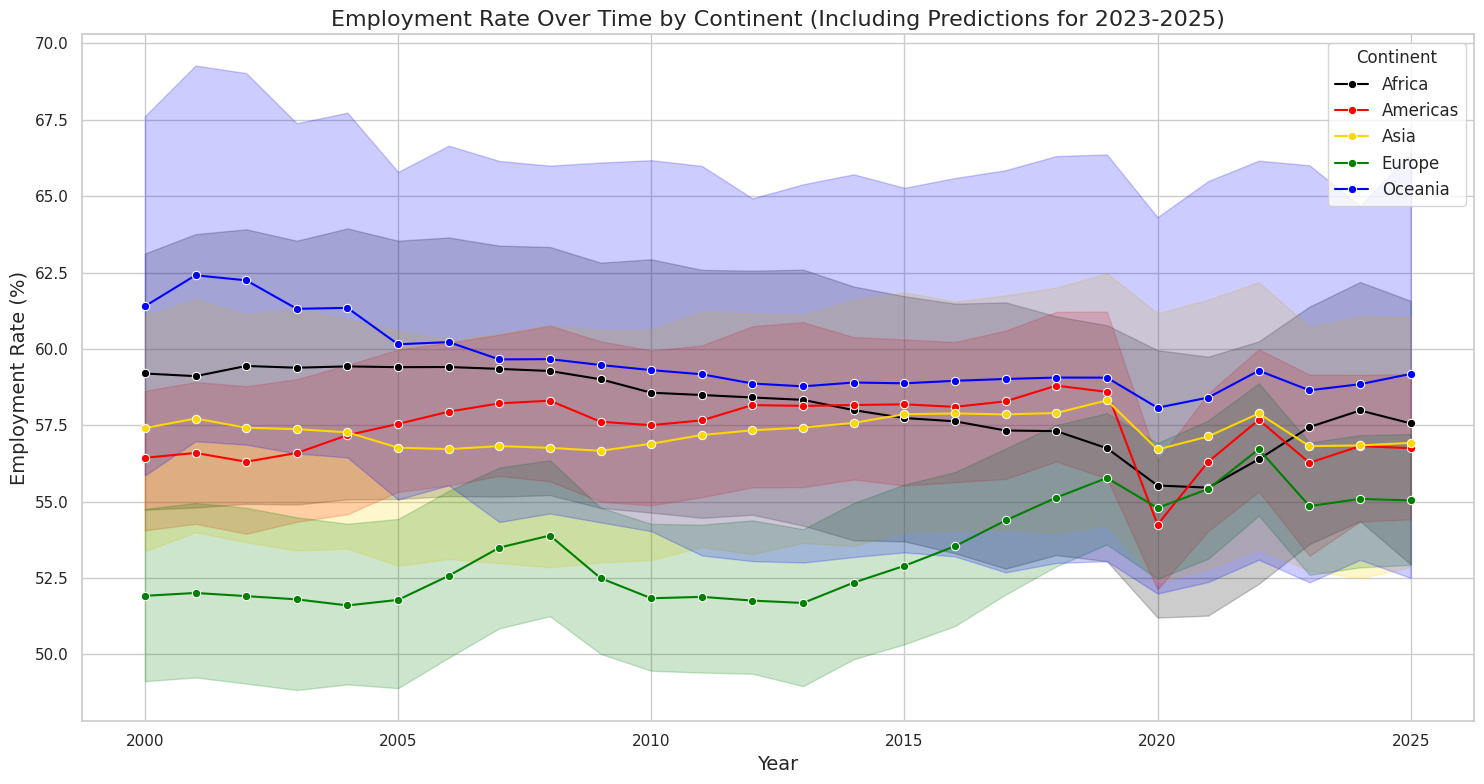

In [128]:
### Final Visualization of Employment Rate Prediction 2023 to 2025

# Remove existing 'Continent' column from forecast_combined if it exists
if 'Continent' in forecast_combined.columns:
    forecast_combined.drop(columns=['Continent'], inplace=True)

# Add 'Continent' column to forecast_combined by merging with historical data
forecast_combined = forecast_combined.merge(
    df_renamed[['Country Name', 'Continent']].drop_duplicates(),
    on='Country Name',
    how='left'
)

# Combine historical and forecasted data
combined_data = pd.concat([
    df_renamed[['Country Name', 'Year', 'Employment Rate', 'Continent']],
    forecast_combined[['Country Name', 'Year', 'Predicted Employment Rate', 'Continent']]
])

# Rename 'Predicted Employment Rate' to 'Employment Rate' for consistency
combined_data['Employment Rate'] = combined_data['Employment Rate'].fillna(combined_data['Predicted Employment Rate'])

# Drop the 'Predicted Employment Rate' column as it's now merged
combined_data.drop(columns=['Predicted Employment Rate'], inplace=True)

# Sort the data for better visual continuity
combined_data.sort_values(by=['Continent', 'Country Name', 'Year'], inplace=True)

# Plot time series for each continent, including historical and predicted data
plt.figure(figsize=(15, 8))

sns.lineplot(
    data=combined_data,
    x='Year',
    y='Employment Rate',
    hue='Continent',
    marker='o',
    palette=['black', 'red', 'gold', 'green', 'blue']
)

# Add plot details
plt.title('Employment Rate Over Time by Continent (Including Predictions for 2023-2025)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Employment Rate (%)', fontsize=14)
plt.legend(title='Continent', fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [129]:
#  Createing an interactive dashboard using Dash to visualize
# employment rate predictions (2023–2025) by country, featuring a dropdown menu
# for country selection, a prediction table, line and bar graphs for trends,
# and a global choropleth map to display employment rates across countries.

# Load your data
data = pd.read_csv('predicted_employment_rate_2023_2025.csv')

# Rename columns for consistency
data.rename(columns={'Predicted Employment Rate': 'Employment Rate'}, inplace=True)

# Initialize the Dash app
app = dash.Dash(__name__)

# Layout of the app
app.layout = html.Div(
    style={'backgroundColor': '#f2f2f2', 'padding': '10px'},
    children=[
        html.H1("Employment Rate Prediction Dashboard",
                style={'text-align': 'center', 'color': '#004d99', 'font-family': 'Arial, Helvetica, sans-serif', 'font-size': '24px'}),

        # Dropdown menu for selecting a country
        html.Div([
            html.Label("Select a Country:", style={'color': '#004d99', 'font-size': '16px'}),
            dcc.Dropdown(
                id='country-dropdown',
                options=[{'label': country, 'value': country} for country in data['Country Name'].unique()],
                value=data['Country Name'].unique()[0],  # Default value
                style={'width': '40%', 'margin': '0 auto'}
            )
        ], style={'text-align': 'center', 'margin-bottom': '10px'}),

        # Display the table of predictions
        html.Div(id='prediction-table', style={'text-align': 'center', 'margin-bottom': '10px'}),

        # Horizontal alignment for the two graphs
        html.Div([
            dcc.Graph(id='employment-trend-graph', style={'display': 'inline-block', 'width': '45%'}),
            dcc.Graph(id='employment-bar-graph', style={'display': 'inline-block', 'width': '45%'})
        ], style={'text-align': 'center', 'margin-bottom': '20px'}),

        # World map
        dcc.Graph(id='employment-map', style={'width': '100%', 'height': '700px'}),  # Increased height for the map

        # Placeholder for employment rates below the map
        html.Div(id='employment-rates', style={'text-align': 'center', 'margin-top': '10px', 'font-size': '14px'})
    ]
)

# Callback to update the graphs and map based on the selected country
@app.callback(
    [Output('prediction-table', 'children'),
     Output('employment-trend-graph', 'figure'),
     Output('employment-bar-graph', 'figure'),
     Output('employment-map', 'figure'),
     Output('employment-rates', 'children')],
    [Input('country-dropdown', 'value')]
)
def update_output(selected_country):
    # Filter data for the selected country
    country_data = data[data['Country Name'] == selected_country]

    # Check if there is data for the selected country
    if country_data.empty:
        return (html.Div(f"No data available for {selected_country}"), go.Figure(), go.Figure(), go.Figure(), html.Div(f"No data available for {selected_country}"))

    # Create the predictions table
    predictions = country_data[['Year', 'Employment Rate']]
    prediction_table = html.Table(
        children=[
            html.Thead(html.Tr([html.Th("Year", style={'padding': '5px', 'backgroundColor': '#004d99', 'color': '#ffffff', 'font-size': '14px'}),
                                html.Th("Predicted Employment Rate", style={'padding': '5px', 'backgroundColor': '#004d99', 'color': '#ffffff', 'font-size': '14px'})])),
            html.Tbody([
                html.Tr([html.Td(row['Year'], style={'padding': '4px', 'border': '1px solid #ddd', 'font-size': '14px'}),
                         html.Td(round(row['Employment Rate'], 2), style={'padding': '4px', 'border': '1px solid #ddd', 'font-size': '14px'})])
                for _, row in predictions.iterrows()
            ])
        ],
        style={
            'margin': '0 auto',
            'width': '40%',
            'border': '1px solid #ddd',
            'border-collapse': 'collapse',
            'font-family': 'Arial, Helvetica, sans-serif',
            'font-size': '14px'
        }
    )

    # Create the line graph
    line_fig = go.Figure()
    line_fig.add_trace(go.Scatter(
        x=country_data['Year'],
        y=country_data['Employment Rate'],
        mode='lines+markers',
        marker=dict(size=6, color='#004d99'),
        line=dict(width=2),
        name='Employment Rate'
    ))
    line_fig.update_layout(
        title=f'Employment Rate Trends for {selected_country} (2023–2025)',
        xaxis_title='Year',
        yaxis_title='Employment Rate (%)',
        title_font=dict(size=16, color='#004d99'),
        plot_bgcolor='#f9f9f9'
    )

    # Create the bar graph
    bar_colors = ['#ff9999', '#66b3ff', '#99ff99']
    bar_fig = go.Figure()
    for i, year in enumerate(country_data['Year']):
        bar_fig.add_trace(go.Bar(
            x=[year],
            y=[country_data[country_data['Year'] == year]['Employment Rate'].values[0]],
            name=str(year),
            marker_color=bar_colors[i]
        ))
    bar_fig.update_layout(
        title=f'Employment Rate Bar Graph for {selected_country} (2023–2025)',
        xaxis_title='Year',
        yaxis_title='Employment Rate (%)',
        title_font=dict(size=16, color='#004d99'),
        plot_bgcolor='#f9f9f9',
        barmode='group'
    )

    # Create the choropleth map
    map_fig = px.choropleth(
        data,
        locations="Country Name",
        locationmode="country names",
        color="Employment Rate",
        hover_name="Country Name",
        hover_data={"Year": True, "Employment Rate": True},
        animation_frame="Year",
        color_continuous_scale=px.colors.sequential.Plasma,
        title="Global Employment Rate (2023–2025)"
    )
    map_fig.update_layout(
        title_font=dict(size=18, color='#004d99'),
        plot_bgcolor='#f9f9f9',
        geo=dict(showframe=False, showcoastlines=True, projection_type="natural earth"),
        height=700
    )

    # Extract employment rates for the selected country
    rates_info = html.Div(
        [
            html.H4(f"Employment Rates for {selected_country} (2023–2025):", style={'color': '#004d99'}),
            html.Ul([
                html.Li(f"{row['Year']}: {round(row['Employment Rate'], 2)}%") for _, row in country_data.iterrows()
            ])
        ]
    )

    return prediction_table, line_fig, bar_fig, map_fig, rates_info


# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>